# Food: a relevant marker of social inequalities?

In [2]:
# Imports
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import numpy as np
import folium
import re
import platform
import os
import pyspark
import warnings

from scipy.stats import *
from urllib.request import urlopen
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from pyspark.sql import *
from pyspark.sql.functions import *
from sklearn.decomposition import PCA
from bokeh.io import show, output_notebook, output_file, save
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, BoxAnnotation, Label, CategoricalColorMapper
from bokeh.transform import jitter

# Uncomment to hide Warnings
warnings.filterwarnings('ignore')

In [2]:
# Constants
FIG_SIZE=(12,10)

We've got two datasets: the OpenFoodFact dataset and the INCA study. As we suspected (cf. milestone 1) they are difficult to join. However they are quite complementary: the OpenFoodFact gives us information about products sold in supermarkets and the INCA study gives us information about people's food habits, health and way of life.

## Open Food Fact 

Study of OpenFoodFactt is a world wide study aiming at recording data about food products available in supermarket. It contains information about nutritional values, labels, brands, sale coutries and many others. The only piece of information not available is the price of the object. This absence is understandable since price for the same object is not the same at all according to its sale place. 

With this study, we aim at studying:
<ul>
<li>The differences between two food categories (*e.g.* organic vs non-organic food)</li>
<li>The nutritional differences beteen supposedly high quality brands vs low cost ones (*e.g.* Panzani vs Marque Repère)</li>
<li>The differences between food in France or in United-States</li>
</ul>

By studying the differences between food of different "quality", origin or growing method, we hope finding out that one is healthier than the other. 

This database is mostly composed of french products sold in french supermarkets such as *Carrefour* or *Auchan*. Thus, we will probably need to consider only products sold in France or do some resampling in the data base in order to take into account the great differences between the amount of data available in each country.

### Data cleaning

In [10]:
# Data
OFF_API_PATH = "https://world.openfoodfacts.org/{}.json"
OFF_API_QUERY_PATH = "https://world.openfoodfacts.org/cgi/search.pl?{}&page_size=1000&action=process&json=1"

def getOFFDataFrame(adress, path = OFF_API_PATH):
    """
    Queries OFF database with local adress contained in adress. Formatting url is contained in path.
    """
    result = json.load(urlopen(path.format(adress)))
#     print("{} entries gathered".format(result["count"]))
    if "products" in result:
        return pd.DataFrame(result["products"])
    return pd.DataFrame(result["tags"])

def getOFFDataFrameDict(qdict, n = 1000):
    """
    Gathers OFF dataframe with query contained in dictionary qdict.
    """
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    return getOFFDataFrame(q, OFF_API_QUERY_PATH)

def getOFFDataFrameDictAux(qdict, n = 1000, log=False):
    """
    Gathers OFF dataframe with query contained in dictionary qdict.
    """
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    i = 1
    dfs = []
    nbCurr = -1
    nbSamples = 0
    while (nbCurr != 0) & (nbSamples < n):
        dfs.append(getOFFDataFrame(q + "&page=" + str(i), OFF_API_QUERY_PATH))
        nbCurr = dfs[-1].shape[0]
        nbSamples += nbCurr
        i += 1
        if log: 
            print("{} samples gathered.".format(nbSamples))
    return pd.concat(dfs).head(n)

def getOFFDataFrameCat(tags=[], nutriments=[], n = 1000, log=False, **kwargs):
    """
    Queries the OFF data base with query informations contained in tags and nutriments. 
    <ul>
        <li>Tags should be a list of lists of shape: 
        [tag, value, &lt;conatins&gt;] where tag is the category of tag (ex. "brands") and value, the value to 
        be searched (ex. "Carrefour")</li>
        <li>Nutriments should be a list of lists of shape: [nutriment, comparison, value] where nutriment is the name of the nutriment to be 
        searched (ex. "magnesium"), comparison the nature of the comparison (ex. "lte") and 
        value the value to be compared with (ex. 50)</li>
    </ul>
    """
    qdict = {}
    qdict.update(parseTags(tags))
    qdict.update(parseNutriments(nutriments))
    qdict.update(kwargs)
    
    return getOFFDataFrameDictAux(qdict, n, log)

def parseTags(tags):
    """
    Converts tags into an appropriate dictionary like shape
    """
    qdict = {}
    for i, tagsEl in enumerate(tags):
        if len(tagsEl) == 2:
            contains = True
        else:
            contains = tagsEl[2]
        qdict["tagtype_{}".format(i)] = tagsEl[0]
        qdict["tag_contains_{}".format(i)] = ["does_not_contain","contains"][int(contains)]
        qdict["tag_{}".format(i)] = tagsEl[1]
    return qdict

def parseNutriments(nutriments):
    """
    Converts nutriments into an appropriate dictionary like shape
    """
    qdict = {}
    for i, nutrimentsEl in enumerate(nutriments):
        qdict["nutriment_{}".format(i)] = nutrimentsEl[0]
        qdict["nutriment_compare_{}".format(i)] = nutrimentsEl[1]
        qdict["nutriment_value_{}".format(i)] = nutrimentsEl[2]
        nutriment_i += 1
    return qdict

### Data formatting

In [56]:
CONVERT_TABLE = {
    "kcal":4.19,
    "kJ":1,
    "g":1,
    "mg":1e-3,
    "µg":1e-6,
    "score":1}
def getConvert(unit):
    return CONVERT_TABLE.setdefault(unit, np.nan)

### Data visualization

In [75]:
def getCategories(df, minlength=4, maxlength=20):
    """
    Gathers the categories from the data frame and split the category text in individual words. 
    Consider only words with length in a specific range.
    """
    cats = pd.DataFrame([x.lower() for cats in df["categories"] for x in re.split("\W", str(cats))], columns=["categories"])
    return cats[cats["categories"].apply(lambda x: (len(x) >= minlength) & (len(x) <= maxlength))]

def generateWordCloud(df, stopwordsAdd={},figsize=FIG_SIZE, **kwargs):
    """
    Generates a wordCloud with categories of products contained in the data frame.
    """
    stopwords = set(STOPWORDS)
    stopwords.update(stopwordsAdd)
    kwargsWC = {"background_color":"white", "stopwords":stopwords, "collocations":False, "width":720, "height":480, "margin":0, "colormap":"inferno"}
    kwargsWC.update(kwargs)
    categories = getCategories(df)
    categoriesText = " ".join(categories["categories"])
    
    wc = WordCloud(**kwargsWC).generate(categoriesText)

    # Display the generated image:
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

def generate_mask(path):
    """
    Generates a wordcloud mask out of an image
    """
    im = np.array(Image.open(path))
    im = im.mean(axis=2, dtype="int16")
    im = 255 * (im > 240)
    return im

def contains(strList, container):
    """
    Checks whether the container contains one element of the list.
    """
    for s in strList:
        if s in container:
            return True
    return False

def toFloat(x):
    """
    Converts x into float or nan
    """
    try:
        return float(x)
    except:
        return np.nan

def gatherCategory(df, categories):
    """
    Gather every products with category containing one of the key words.
    """
    return df[df["categories"].apply(lambda x: contains(categories, str(x)))]

def gatherNutriments(df, nutriment, p=5):
    """
    Gather the nutritional values for the products if it is defined.
    """
    if "score" in nutriment:
        vals = df["nutriments"].apply(lambda x: toFloat(x.setdefault("{}_100g".format(nutriment), np.nan))).dropna().values
    else:
        vals = df["nutriments"].apply(lambda x: toFloat(x.setdefault("{}_100g".format(nutriment), np.nan)) * getConvert(x.setdefault("{}_unit".format(nutriment), ""))).dropna().values
    if len(vals) == 0:
        return np.array([])
    vMin = np.percentile(vals, p)
    vMax = np.percentile(vals, 100 - p)
    return np.array(vals[(vals >= vMin) & (vals <= vMax)])

def gatherUnit(df, nutriment):
    """
    Gather a possible unit for the nutriment.
    """
    if "score" in nutriment:
        return "score"
    vals = df["nutriments"].apply(lambda x: x.setdefault("{}_unit".format(nutriment), np.nan)).dropna().values
    if len(vals) > 0:
        return vals[0]
    return ""

### Data analysis

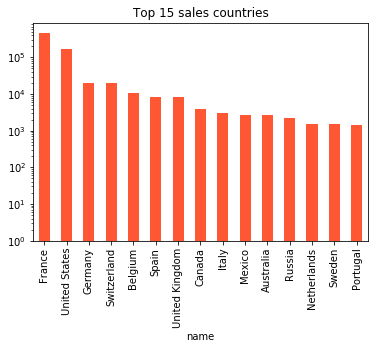

In [5]:
countriesDf = getOFFDataFrame("countries")
countriesDf = countriesDf.sort_values("products", ascending=False)
df = countriesDf.head(15)
df.plot.bar(x="name", y="products", legend=False, log=True, facecolor="#FF5733")
plt.title("Top 15 sales countries")
plt.show()

In [6]:
countriesDf["proportion"] = (countriesDf["products"] / countriesDf["products"].sum()).apply(lambda x: "{:.2f}%".format(x*100))
countriesDf[["name", "proportion"]].head(10)

name proportion
0          France     61.64%
1   United States     23.91%
2         Germany      2.72%
3     Switzerland      2.66%
4         Belgium      1.46%
5           Spain      1.15%
6  United Kingdom      1.12%
7          Canada      0.53%
8           Italy      0.42%
9          Mexico      0.37%

This histogram shows that most of the products have been recorded in France (62%) or in the United States (24%). The two of them cover 85% of the samples. For this reason, we will need to operate carefully when effecting comparisons between states.

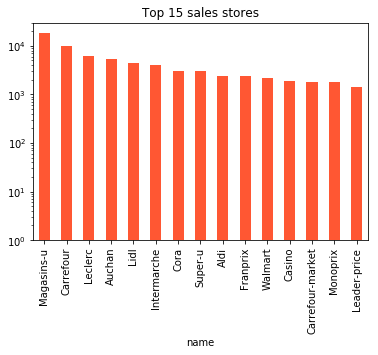

In [74]:
storesDf = getOFFDataFrame("stores")
storesDf = storesDf.sort_values("products", ascending=False)
df = storesDf.head(15)
df.plot.bar(x="name", y="products", legend=False, log=True, facecolor="#FF5733")
plt.title("Top 15 sales stores")
plt.show()

As expected, the most represented stores are french stores. The first foreign store represented is Walmart.

### Organic food

#### Milestone 3: organic food history

To introduce the topic of organic food consumption in France, in our data story, we want to visualize a map of organic agriculture land evolution in France. Unfortunately data is available since 2008, 2009, 2010 and 2011 so we cannot have an overview of this evolution over many years. We use data freely available on french open data.

In [5]:
plat = platform.system()
if plat =="Windows":
    encoding = "ansi" # Windows
elif plat =="Darwin":
    encoding = "latin" # Mac
else:
    raise ValueError("unknown os: {}".format(plat))

# Names of the great regions
REGIONS = ["ARA", "BFC", "BR", "CO", "CVL", "GE", "HF", "IDF", "NA", "NO", "OC", "PACA", "PL"]
ORG_PATH = "data/Syntheses_regionales_XLS/{}.xlsx"

dfs = []

# Importing data for organic fields
for reg in REGIONS:
    df = pd.read_excel(ORG_PATH.format(REGIONS[0]), sheetname = "graph_evol", skiprows=3)
    columns = {"Année":"year", 
              "   Nombre d'exploitations":"farm_number", 
              "   Surfaces certifiées bio": "surfaces",
              "   Nb. de transformateurs, distributeurs et importateurs": "transformers"}

    df = df[list(columns.keys())]
    df = df.rename(columns=columns).dropna()
    df = df.astype({"farm_number":"int32", "transformers":"int32", "year":"int32", "surfaces":"float"})
    df["region"] = reg
    dfs.append(df)

dfOrganic = dfs[0].append(dfs[1:])
dfOrganic["id"] = dfOrganic["region"] + dfOrganic["year"].astype("str")

# Importing data for all agriculture
dfSAU = pd.read_csv("data/SAANR_1.csv", encoding="ansi", sep=";")

dfsSAUReg = []
for col in dfSAU.columns:
    if col != "Année":
        [reg, code] = col.split("-")
        df = dfSAU[["Année", col]].rename(columns={"Année": "year", col:"SAU"}) 
        df["region"]=reg
        df["code"]=code
        dfsSAUReg.append(df)
dfSAUReg = dfsSAUReg[0].append(dfsSAUReg[1:])
dfSAUReg["id"] = dfSAUReg["region"] + dfSAUReg["year"].astype("str")

# Merging dataframes
dfRegionsAll = dfOrganic.merge(dfSAUReg[["SAU", "id", "code"]], left_on="id", right_on="id")
dfRegionsAll["nonOrg_surface"] = dfRegionsAll["SAU"] - dfRegionsAll["surfaces"]
dfRegionsAll["orgProp"] = dfRegionsAll["surfaces"] / dfRegionsAll["SAU"] * 100

We can have a look at the evolution of the proportion of organic fields through this period of time:

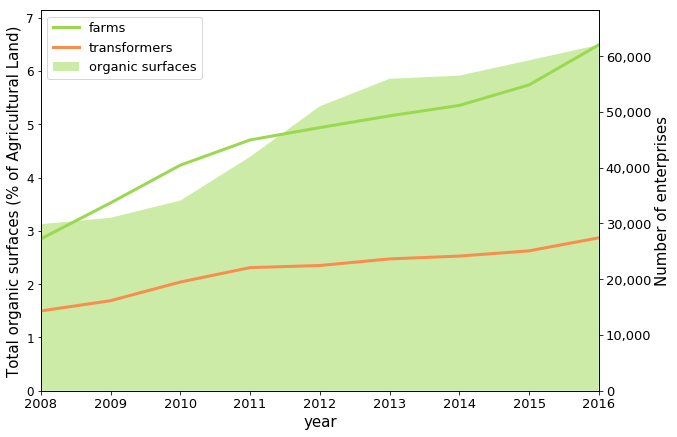

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
dfYear = dfRegionsAll.groupby("year").agg({"year":"max", "region":"count", "SAU":"sum", "surfaces": "sum", "farm_number":"sum", "transformers": "sum"})
dfYear["organic_prop"] = dfYear["surfaces"] / dfYear["SAU"] * 100
ax.stackplot(dfYear["year"], [dfYear["organic_prop"]] , labels=["organic surfaces"], alpha=0.5, colors=["#9ad94f"])
ax.set_xlim((np.min(dfYear["year"]), np.max(dfYear["year"])))
ax.set_ylim((0, np.max(dfYear["organic_prop"]) * 1.1))
ax.set_xticklabels(["{:.0f}".format(x) for x in ax.get_xticks()], fontsize=13)
ax.set_yticklabels(["{:.0f}".format(x) for x in ax.get_yticks()], fontsize=12)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("Total organic surfaces (% of Agricultural Land)", fontsize=15)

ax2 = ax.twinx()
ax2.plot(dfYear["year"], dfYear["farm_number"], label="farms", linewidth=3, c="#9ad94f")
ax2.plot(dfYear["year"], dfYear["transformers"], label="transformers", linewidth=3, c="#f98d4f")
ax2.stackplot([], [[], []], labels=["organic surfaces"], alpha=0.5, colors=["#9ad94f"])
ax2.set_ylim((0, dfYear["farm_number"].max()*1.1))
ax2.set_yticklabels(["{:,.0f}".format(x) for x in ax2.get_yticks()], fontsize=13)
ax2.set_ylabel("Number of enterprises", fontsize=15)

ax2.legend(loc="upper left", fontsize=13)

plt.show()

In [7]:
def filterGreatRegions(dataframe, category):
    '''
    Returns the regions with more than 40 persons.
    '''
    regions_geo_path = "data/france-geojson-master/regions-version-simplifiee.geojson"
    geo_json_data = json.load(open(regions_geo_path))
    return geo_json_data


def organic_map(dataframe, category, year, legend):
    '''
    Returns the map of the average value of the studied category for individual of the given age.
    Only displays the regions where there are at least 30 individuals in order to have meaningful values.
    '''
    df = dataframe[[category,"region","year", "code"]]
    df = df[df["year"] == year]
    df["code"] = df["code"].astype(str)
    df[category] = df[category].astype(float)
    
    regions_geo_path = "data/france-geojson-master/regions-version-simplifiee.geojson"
    geo_json_data = json.load(open(regions_geo_path))
    
    m_france = folium.Map([46.6, 4], zoom_start=5, no_touch =True)
    m_france.choropleth(
        geo_data=geo_json_data,
        threshold_scale = [0, 2, 4, 6, 10, 15],
        data=df,
        columns=['code', category],
        key_on='feature.properties.code',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.7,
        legend_name=legend,
        highlight=True
    )
    return m_france

In [8]:
for year in range(2008, 2017):
    m = organic_map(dfRegionsAll, "orgProp", year, "Organic proportion")
    m.save("outputs/organic_surfaces_{}.html".format(year))

m

A quick look at these maps shows that most of the regions have a quite similar proportion of organic fields. Only Ile-de-France and the South-East regions have a higher density of organic fields.

#### Milestone 2 : study of organic food in the OpenFoodFact database

In [8]:
organicDf = getOFFDataFrameCat(tags = [["labels", "organic"]], n= 20000)
nonOrganicDf = getOFFDataFrameCat(tags = [["labels", "organic", False]], n=30000)

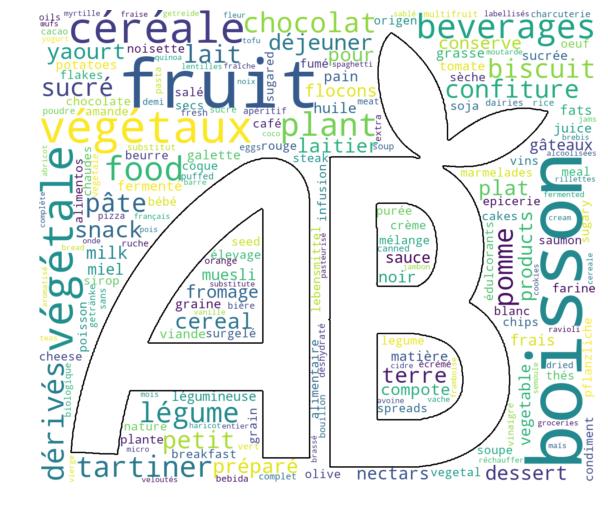

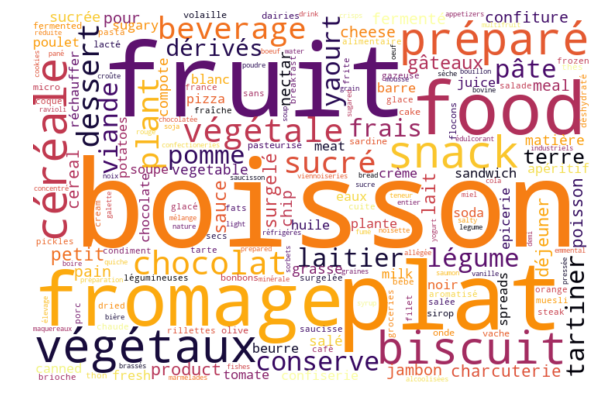

In [9]:
stopwords = {"base", "based", "origine", "produits", "aliment", "aliments"}
maskAB = generate_mask("data/images/logo-ab.jpg")
generateWordCloud(organicDf, stopwords, figsize = (10, 10), colormap = "viridis", mask=maskAB,contour_width=3, contour_color='black')
generateWordCloud(nonOrganicDf, stopwords, figsize = (10, 10), colormap = "inferno")

By looking at the wordclouds, it appears that organic and non organic products cover essetially the same markets. They are both essentially covering *drinks*, *fruits* and *vegetables*. However, they differ on many items. For instance, organic food is more interested in *cereals* and raw food, when non organic one covers more transformed food and already cooked meals.

Most of the words are in French because most of the products in the data set are sold in France.

#### Cereal example

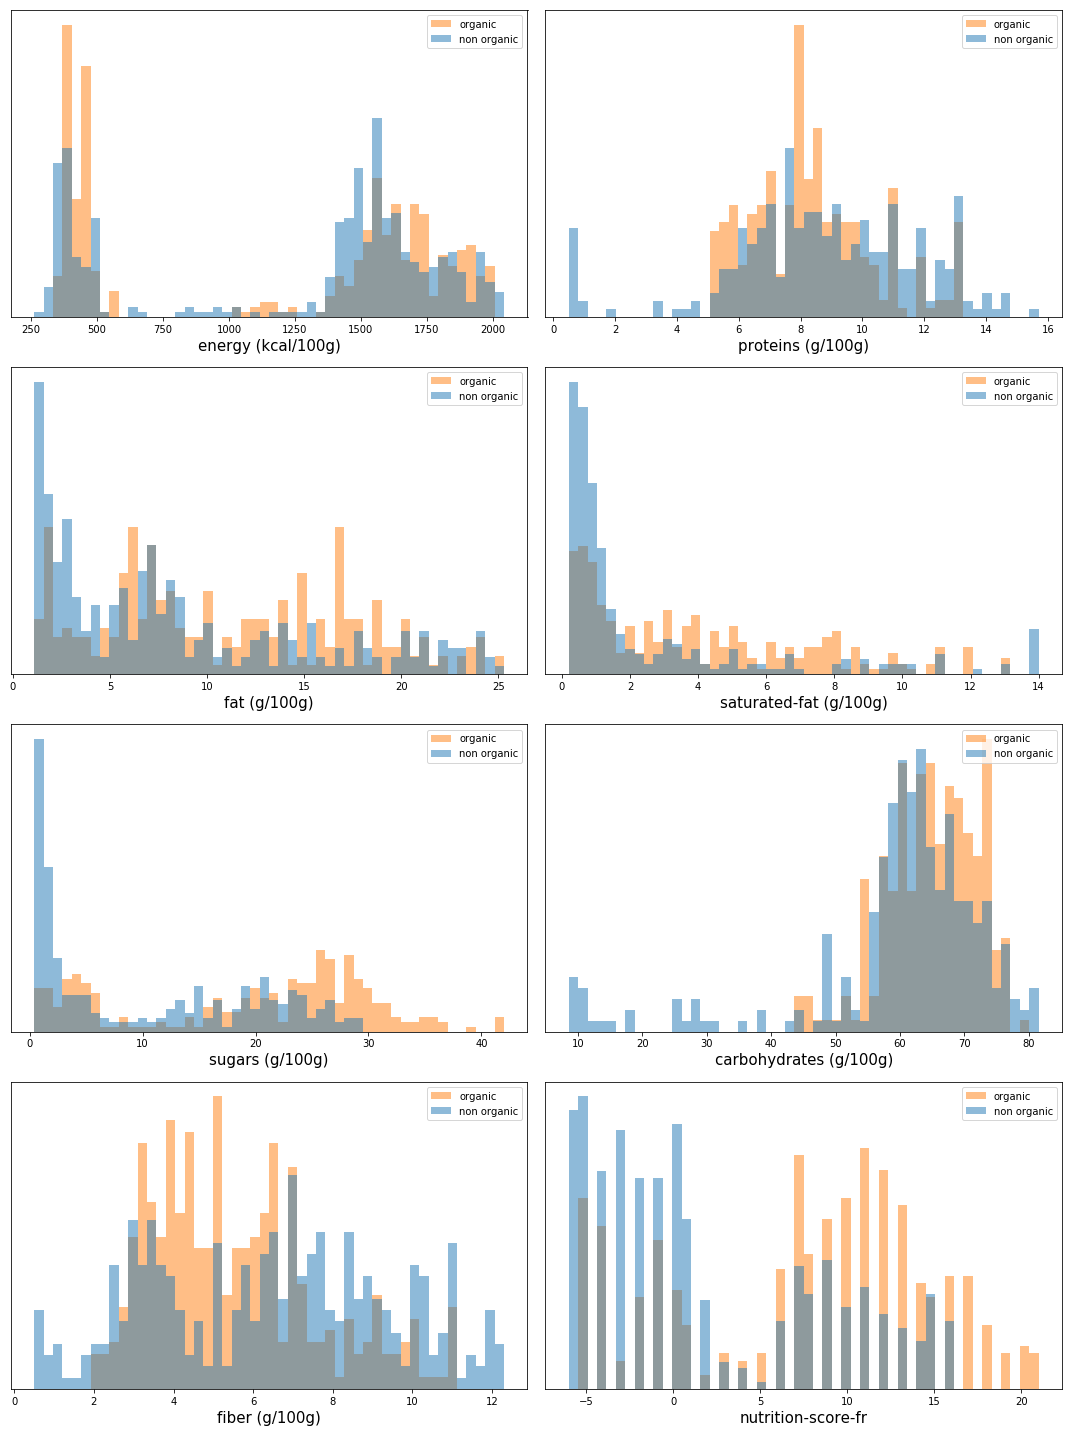

In [72]:
# Selecting cereals
cats = ["céréales"]
catOrganic = gatherCategory(organicDf, cats)
catNOrganic = gatherCategory(nonOrganicDf, cats)
nutriments = ["energy","proteins","fat", "saturated-fat", "sugars","carbohydrates","fiber","nutrition-score-fr"]


fig, axes = plt.subplots(4, 2, figsize=(15, 20))
for i, nutriment in enumerate(nutriments):
    # Finding the unit and converting the values in the same unit
    unit = gatherUnit(catOrganic, nutriment)
    orgNut = gatherNutriments(catOrganic, nutriment) / getConvert(unit)
    nOrgNut = gatherNutriments(catNOrganic, nutriment) / getConvert(unit)
    
    # Plotting
    if (np.mean(orgNut) > 0) &  (np.mean(nOrgNut) > 0):
        ax = axes[i // 2, i % 2]
        ax.hist([orgNut, nOrgNut], density=True, bins=50, histtype ="stepfilled", alpha=0.5)
        if unit=="score":
            ax.set_xlabel(nutriment, fontsize=15)
        else:
            ax.set_xlabel("{} ({}/100g)".format(nutriment, unit), fontsize=15)
        ax.set_yticks([])
        ax.legend(["organic", "non organic"])
fig.tight_layout()
plt.show()

If we look more specifically at one category, for example *cereals*, we see that most of essential nutriments taken individually do not have a really different distribution between organic and not organic products. A striking fact is that the nutri-score for organic cereals is globally worse than the one for non-organic products.

This fact can be explained by the fact that organic food is only a label that guaranties that here is no pesticides and no controversal additives, but not that food contains less sugar or less fats.

In a further study, we should study why there are two peaks in the energy histogram. Is it due to a subclass of sereals or a mistake with the unit of the energy? (There is approximately a factor 4 between the two groups, mistakes between *kcal* and *kJ* could be an explanation.)

#### Drink example

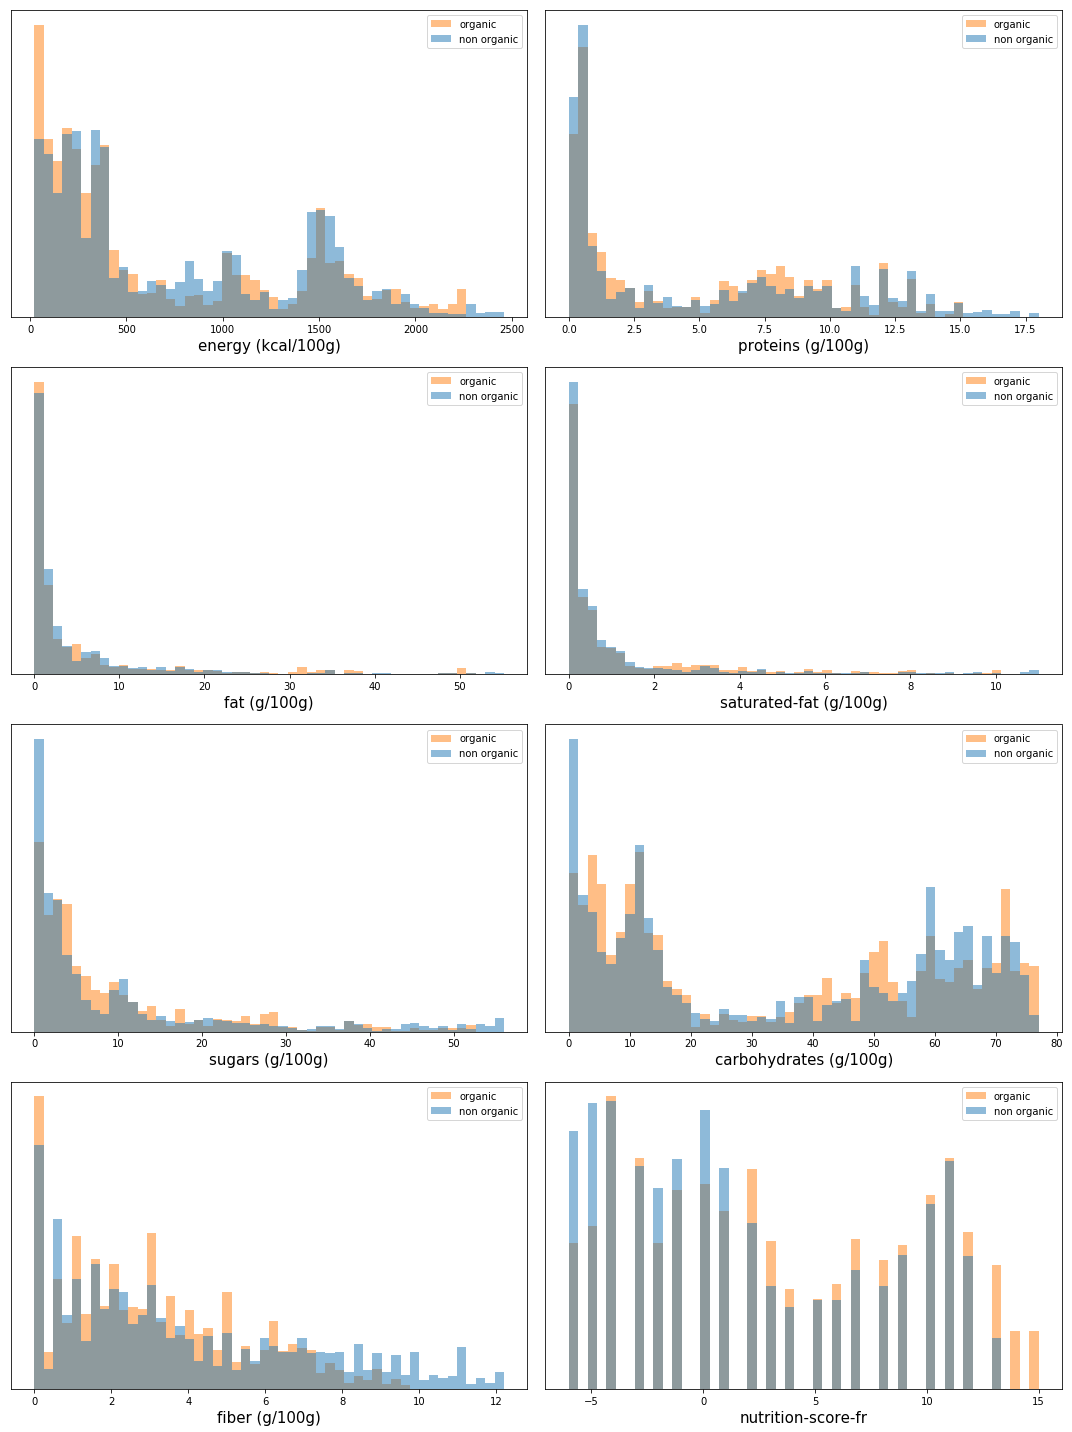

In [73]:
# Selecting drinks
cats = ["boisson"]
catOrganic = gatherCategory(organicDf, cats)
catNOrganic = gatherCategory(nonOrganicDf, cats)


fig, axes = plt.subplots(4, 2, figsize=(15, 20))
for i, nutriment in enumerate(nutriments):
    # Finding the unit and converting the values in the same unit
    unit = gatherUnit(catOrganic, nutriment)
    orgNut = gatherNutriments(catOrganic, nutriment) / getConvert(unit)
    nOrgNut = gatherNutriments(catNOrganic, nutriment) / getConvert(unit)
    
    # Plotting
    if (np.mean(orgNut) > 0) &  (np.mean(nOrgNut) > 0):
        ax = axes[i // 2, i % 2]
        ax.hist([orgNut, nOrgNut], density=True, bins=50, histtype ="stepfilled", alpha=0.5)
        if unit=="score":
            ax.set_xlabel(nutriment, fontsize=15)
        else:
            ax.set_xlabel("{} ({}/100g)".format(nutriment, unit), fontsize=15)
        ax.set_yticks([])
        ax.legend(["organic", "non organic"])
fig.tight_layout()
plt.show()

If we look more specifically at another category, for example *drinks*, it seems that even the nutrition score does not differ between the two products.

This lack of difference suggests that there must be another criterion that could differ between organic and non organic food. For instance additives or controversal substances.

### Milestone 3: stores comparison

In [11]:
prodDf = getOFFDataFrameCat(n= 40000)

In [24]:
def get_nutrients(df):
    nutrients = set()
    df.head(100)["nutriments"].apply(lambda x: nutrients.update(x.keys()))
    return list(nutrients)

def ravel_nutrients(df):
    nutrients = get_nutrients(df)
    for nutrient in nutrients:
        df[nutrient] = pd.to_numeric(df["nutriments"].apply(lambda x: x.setdefault(nutrient, np.nan)), errors="coerce")
    return df

def compare(comparison, score, xlabel, ylabel):
    '''
    Compare the nutriscore for the given category
    '''
    prodNutScoreDf = prodDf[~np.isnan(prodDf[score])]
    comparisonDf = prodNutScoreDf[prodNutScoreDf[comparison] != ""]\
        .groupby(comparison).agg({comparison: "max", "code": "count", score: "mean"})\
        .sort_values("code", ascending=False)\
        .head(10)\
        .sort_values(score, ascending=False)
    comparisonList = comparisonDf[comparison]

    fig, ax = plt.subplots(figsize=(10, 7))
    nutriScoreData = [prodNutScoreDf[prodNutScoreDf[comparison] == store][score] for comparison in comparisonList]
    ax.boxplot(nutriScoreData, labels=storesList)
    # prodNutScoreRelevantDf = prodNutScoreDf[prodNutScoreDf[compare].isin(storesList)]
    # prodNutScoreRelevantDf.boxplot("nutrition-score-fr", by=compare, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    gradient = np.linspace(1, 0, 100).reshape(-1, 1)
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    ax.imshow(gradient , extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', cmap='RdYlGn_r', alpha=0.5)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.show()

In [22]:
prodDf = ravel_nutrients(prodDf)

In [25]:
compare("stores", "nutrition-score-fr", "Store", "Nutriscore (FR)")

NameError: name 'storesDf' is not defined

In [ ]:
def ttest_perso(df, where, def ttest_perso(df, where, equals_0, equals_1, column):
    df0 = df[df[where] == equals_0][column]
    df1 = df[df[where] == equals_1][column]
    return ttest_ind(df0, df1, axis=0, equal_var=False)

for store_0, store_1 in zip(storesList[:-1], storesList[1:]):
    print("{: <15} - {: <15}: {:.2e}".format(store_0, store_1, ttest_perso(prodNutScoreDf, compare, store_0, store_1, "nutrition-score-fr").pvalue))

n = len(storesList)
pvals = np.ones((n, n))
fig, ax = plt.subplots(figsize=(7, 7))
for i in range(n):
    for j in range(i):
        t = ttest_perso(prodNutScoreDf, compare, storesList[i], storesList[j], "nutrition-score-fr").pvalue
        pvals[i, j] = t
        pvals[j, i] = t
        
vmin = -7

im = ax.imshow(np.log10(pvals), vmin=vmin, vmax =0)
cbar = fig.colorbar(im, ticks=range(vmin, 1), orientation='vertical')
cbar.ax.set_yticklabels(["$<10^{}{}{}$".format("{", vmin, "}")] + ["$10^{}{}{}$".format("{", i, "}") for i in range(vmin+1, 1)])

ax.set_xticks(range(n))
ax.set_xticklabels(storesList, rotation=75, ha="right")
ax.set_yticks(range(n))
ax.set_yticklabels(storesList)
ax.set_title("$p$-value of the $t$-test between the \nnutriscore distributions between stores.")
plt.show(), equals_1, column):
    df0 = df[df[where] == equals_0][column]
    df1 = df[df[where] == equals_1][column]
    return ttest_ind(df0, df1, axis=0, equal_var=False)

for store_0, store_1 in zip(storesList[:-1], storesList[1:]):
    print("{: <15} - {: <15}: {:.2e}".format(store_0, store_1, ttest_perso(prodNutScoreDf, compare, store_0, store_1, "nutrition-score-fr").pvalue))

n = len(storesList)
pvals = np.ones((n, n))
fig, ax = plt.subplots(figsize=(7, 7))
for i in range(n):
    for j in range(i):
        t = ttest_perso(prodNutScoreDf, compare, storesList[i], storesList[j], "nutrition-score-fr").pvalue
        pvals[i, j] = t
        pvals[j, i] = t
        
vmin = -7

im = ax.imshow(np.log10(pvals), vmin=vmin, vmax =0)
cbar = fig.colorbar(im, ticks=range(vmin, 1), orientation='vertical')
cbar.ax.set_yticklabels(["$<10^{}{}{}$".format("{", vmin, "}")] + ["$10^{}{}{}$".format("{", i, "}") for i in range(vmin+1, 1)])

ax.set_xticks(range(n))
ax.set_xticklabels(storesList, rotation=75, ha="right")
ax.set_yticks(range(n))
ax.set_yticklabels(storesList)
ax.set_title("$p$-value of the $t$-test between the \nnutriscore distributions between stores.")
plt.show()

## Study of INCA 2

### Data cleaning

In [3]:
# Data
plat = platform.system()
if plat =="Windows":
    encoding = "ansi" # Windows
elif plat =="Darwin":
    encoding = "latin" # Mac
else:
    raise ValueError("unknown os: {}".format(plat))

DATA_PATH = "data/{}.csv"

dfConso = pd.read_csv(DATA_PATH.format("Table_conso"), sep=";", encoding=encoding)
dfIndiv = pd.read_csv(DATA_PATH.format("Table_indiv"), sep=";", encoding=encoding)
dfCapiCA = pd.read_csv(DATA_PATH.format("Table_capi_ca"), sep=";", encoding=encoding)
dfCarnetCA = pd.read_csv(DATA_PATH.format("Table_carnet_ca_1"), sep=";", encoding=encoding)
dfIndivCA = pd.read_csv(DATA_PATH.format("Table_indiv_ca"), sep=";", encoding=encoding)
dfIndnut = pd.read_csv(DATA_PATH.format("Table_indnut"), sep=";", encoding=encoding)
dfMenage = pd.read_csv(DATA_PATH.format("Table_menage_1"), sep=";", encoding=encoding)
dfRepas = pd.read_csv(DATA_PATH.format("Table_repas"), sep=";", encoding=encoding)
dfNomenclature = pd.read_csv(DATA_PATH.format("Nomenclature_3"), sep=";", encoding=encoding)
dfCorrespondance = pd.concat([pd.read_csv(DATA_PATH.format("correspondance_reponses"), sep=";", encoding=encoding), pd.read_csv(DATA_PATH.format("correspondance_custom"), sep=";", encoding=encoding)])
dfDataNames = pd.concat([pd.read_csv(DATA_PATH.format("Data_names_all"), sep=";", encoding=encoding), pd.read_csv(DATA_PATH.format("Data_names_custom"), sep=";", encoding=encoding)])
dfValRef = pd.read_csv(DATA_PATH.format("Valeurs_References"), sep=";", encoding=encoding)

dfDataCorrespondance = dfDataNames.merge(dfCorrespondance,left_on="Libellé du codage", right_on="Libellé du codage", how="inner")

#### Sources pour les valeurs de références

http://www.efsa.europa.eu/sites/default/files/2017_09_DRVs_summary_report.pdf

https://www.anses.fr/fr/system/files/NUT2012SA0103Ra-1.pdf

https://fr.wikipedia.org/wiki/Apports_journaliers_recommand%C3%A9s

### Data formating

In [4]:
def findCorrespondance(val, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    try:
        meaning = dfDataCorrespondance[(dfDataCorrespondance["Nom de la variable"] == column) & (dfDataCorrespondance["code"] == val)]["Signification"].values[0]
    except IndexError:
        meaning = val
    return meaning

def mapCorrespondances(vals, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    return [findCorrespondance(val, column) for val in vals]

def findDescription(column):
    """
    Returns the description of the column signification.
    """
    return dfDataNames[(dfDataNames["Nom de la variable"] == column)]["Libellé de la variable"].values[0]

def mapDescription(columns):
    """
    Returns the description of the columns signification.
    """
    return [findDescription(column) for column in columns]

In [5]:
# NB: This is not used for Mileston3. The dataset "dfI" is used instead of dfIndivO18 and cspi2

dfIndivO18 = dfIndiv[dfIndiv["tage"]>=4]
dfIndivO18.loc[:, "sexeps"]= dfIndivO18["sexeps"].values.astype(int)

# Group CSP
# new_category (code) = {old_cat_A (code), old_cat_B (code), ...}
# agriculteur (1) = {agriculteur (1)}
# artisan, commerçant, chef d'entreprise (2) = {artisan (2), commerçant (3), chef d'entreprise (4), profession libérale (5)}
# cadre, prof. intellect. sup. (3) = {cadre, prof. intellect. sup. (6)}
# profession intermédiaire (4) = {contremaître, agent de maitrise (7), technicien (8), autre prof. intermédiaire (9)}
# employé (5) = {employé (10)}
# ouvrier (6) = {ouvrier qualifié (11), ouvrier non qualifié (12)}
# retraité (7) = {retraité(e), pré-retraité(e) (16), retiré des affaires (ancien agri., art.) (17)}
# inactif (8) = {chômeur inscrit ou non à l'anpe (14), etudiant-élève-formation-stage non rémunéré (15), femme ou homme au foyer (18), autre inactif (pension de réversion, invalidité) (19)}
# refus (0) = {refus (13), [refus] (20)}

cspiToCspi2_dict = {1: [1], 2: [2, 3, 4, 5], 3: [6], 4: [7, 8, 9], 5: [10], 6: [11, 12], 7: [16, 17], 8: [14, 15, 18, 19], 0: [13, 20]}

def cspiToCspi2(code):
    for k in cspiToCspi2_dict.keys():
        if code in cspiToCspi2_dict[k]:
            return(k)

serieCspi2 = dfIndivO18["cspi"].apply(lambda x : cspiToCspi2(x))
dfIndivO18 = dfIndivO18.assign(cspi2=serieCspi2)

# Remove the only one "refus"
dfIndivO18 = dfIndivO18[dfIndivO18['cspi2'] != 0]

dfIndivO18["degree3"] = (dfIndivO18["dip"]>5)*1+(dfIndivO18["dip"]>8)*1
type_of_degree = ['No degree', 'Vocational degree', 'General degree']
dfIndivO18.loc[:, "sexeps"]= dfIndivO18["sexeps"].values.astype(int)

### Data analysis and visualization

#### Age distribution

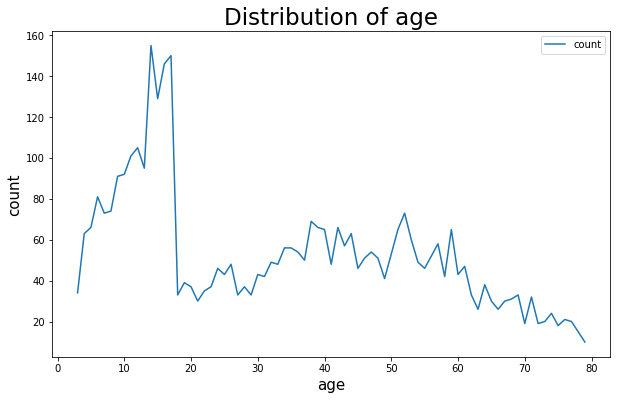

In [87]:
df = dfIndiv.groupby("v2_age").agg({"v2_age":"max", "nomen": "count"}).rename(columns={"nomen": "count"})
df.plot("v2_age", "count", figsize=(FIG_SIZE))
plt.xlabel("age", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.title("Distribution of age", fontsize=23)
plt.show()

Age is not distributed uniformly in the dataset. Many more children were interrogated and there seem to be more 40 or 50-year old people than 20-year old.

#### BMI study

BMI (Body Mass Index) is an indicator frequently used to put in relation the weight and the height of an individual. BMI gives a value that allow to classify people in categories:

- (Very) Severely underweight: less than 16
- Underweight: 16-18.5
- Normal (healthy weight): 18.5-25
- Overweight: 25-30
- Obese Class I (Moderately obese): 30-35
- Obese Class II (Severely obese): 35-40
- Obese Class III-VI (Very severely obese-Hyper Obese): more than 40
_(source Wikipedia)_

The categories given above correspond to adults, we are going to exclude children from our study because their expected BMI changes with age.

Even if this indicator is not perfect (for instance profession athletes use to have a high BMI, synonymous of overweight, whereas they are in very good physical health), it is an easy tool that can allow us to identify some trends in the population.

The BMI is not directly accessible in our dataset but it can easily be computed thanks to the following formula:

$\text{BMI} = \frac{weight}{height^2} \text{kg/cm}^2$

We can study the BMI according to a huge range of categories. In order not to fill the notebook with plenty of figures that are not necessarily easily interpretable we've only let a sample of the figures we found the most significant.

In [ ]:
def BMI_boxplots(dataframe, category, labels, tage=[4,5,6], x_label=None, category_name=None):
    '''
    Plot Body mass index (BMI) of males and females group by the given category.
    '''
    # select useful columns
    df = dataframe[list(set(["sexe_ps","poidsm","taille","tage",category]))]
    # select people in the given age category
    df = df.loc[df["tage"].isin(tage)]
    # compute bmi
    df["bmi"]=df["poidsm"]/((df["taille"]/100)**2)
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # 2 subplots : male and female
    for k in range(1,3):
        df_gender = df.loc[df["sexe_ps"]==k][["bmi",category]]
        count = df_gender[["bmi",category]].groupby(category).count().reset_index()
        df_gender[["bmi", category]].boxplot(by=category, ax=ax[k-1], rot=30)
        ax[k-1].set_ylabel("Body Mass Index (BMI)")
        if(x_label!=None):
            ax[k-1].set_xlabel(x_label)
        else:
            ax[k-1].set_xlabel(category.capitalize())
        labels_n = [labels[i]+"\n n = "+str(count["bmi"][i]) for i in range(len(labels))]
        ax[k-1].xaxis.set_ticklabels(labels_n)
    ax[0].set_title("Males", fontsize=12)
    ax[1].set_title("Females", fontsize=12)
    #background colors
    xrange = [(-1, 10)]
    yrange = [(0, 16.5),(16.5, 2),(18.5, 6.5),(25, 5),(30, 5),(35, 5),(40, 20)]
    colors = ['#21618c','#85c1e9','#58d68d','#FFC300','#FF5733','#C70039','#900C3F']
    for i in range(len(yrange)):
        c0 = collections.BrokenBarHCollection(xrange, yrange[i], facecolor=colors[i], alpha=0.5)
        c1 = collections.BrokenBarHCollection(xrange, yrange[i], facecolor=colors[i], alpha=0.5)
        ax[0].add_collection(c0)
        ax[1].add_collection(c1)
    name = category_name
    if(name==None):
        name = category.lower()
    fig.suptitle('Body mass index evolution with {}'.format(name), fontsize=16)
    plt.show()
    
def t_test(dataframe, gender, category, value_1, value_2):
    '''
    Compute a t-test to see if two series of values have significantly different means.
    '''
    df = dataframe.loc[(dataframe["sexe_ps"]==gender)]
    df["bmi"] = df["poidsm"]/((df["taille"]/100)**2)
    df_0 = df.loc[(df[category]==value_1)][["bmi"]].dropna()
    df_1 = df.loc[(df[category]==value_2)][["bmi"]].dropna()
    return ttest_ind(df_0, df_1, axis=0, equal_var=False)

#### BMI evolution with age

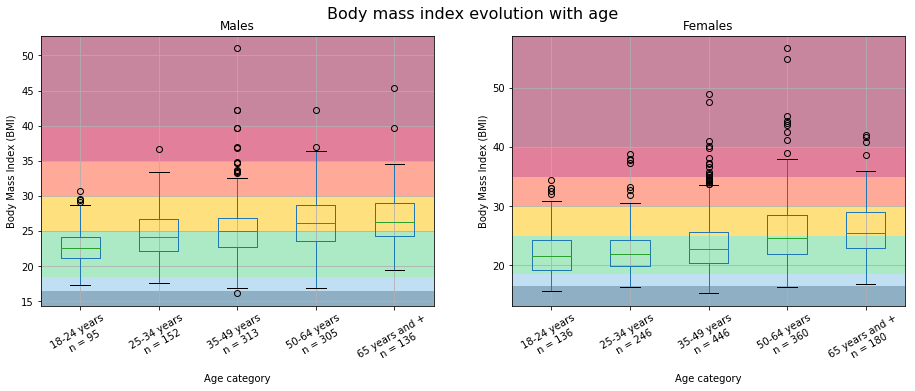

In [41]:
age = ['18-24 years', '25-34 years', '35-49 years', '50-64 years', '65 years and +']
BMI_boxplots(dfIndiv,"tage", age, tage=[4,5,6,7,8], x_label="Age category", category_name="age")

Interestingly we observe the same pattern for males and females (we will see later that it is not always the case). Older people tends to be overweight while younger people have a normal weight. Let's see if this trend is statistically significant.

In [42]:
test = """p_values for:\n
- males   (18-24 years) against males   (25-34 years):    {:.3e}
- males   (25-34 years) against males   (35-49 years):    {:.3e}
- males   (35-49 years) against males   (50-64 years):    {:.3e}
- males   (50-64 years) against males   (65 years and +): {:.3e}
- females (18-24 years) against females (25-34 years):    {:.3e}
- females (25-34 years) against females (35-49 years):    {:.3e}
- females (35-49 years) against females (50-64 years):    {:.3e}
- females (50-64 years) against females (65 years and +): {:.3e}
""".format(float(t_test(dfIndiv, 1, "tage", 4, 5).pvalue),
           float(t_test(dfIndiv, 1, "tage", 5, 6).pvalue),
           float(t_test(dfIndiv, 1, "tage", 6, 7).pvalue),
           float(t_test(dfIndiv, 1, "tage", 7, 8).pvalue),
           float(t_test(dfIndiv, 2, "tage", 4, 5).pvalue),
           float(t_test(dfIndiv, 2, "tage", 5, 6).pvalue),
           float(t_test(dfIndiv, 2, "tage", 6, 7).pvalue),
           float(t_test(dfIndiv, 2, "tage", 7, 8).pvalue),
          )
print(test)

p_values for:

- males   (18-24 years) against males   (25-34 years):    5.967e-05
- males   (25-34 years) against males   (35-49 years):    5.215e-02
- males   (35-49 years) against males   (50-64 years):    7.945e-04
- males   (50-64 years) against males   (65 years and +): 2.900e-01
- females (18-24 years) against females (25-34 years):    6.159e-01
- females (25-34 years) against females (35-49 years):    1.497e-04
- females (35-49 years) against females (50-64 years):    3.916e-08
- females (50-64 years) against females (65 years and +): 4.785e-01



A quick look at the p-values shows that the difference between two adjacent age categories is often significant. We did not displayed the p values for more distant categories (e.g. males (18-24 years) against males (50-64 years)) but they are of course lower.

#### BMI evolution with degree

The dataset gathers a lot of different kind of degrees. We gather them in 3 categories:

- No degree: individual who left school with no degree
- Vocational degree: higher degree is before the baccalauréat or correspond to a vocational/technical baccalauréat
- General degree: higher degree is a general baccalauréat or a university title (bachelor, master,...)

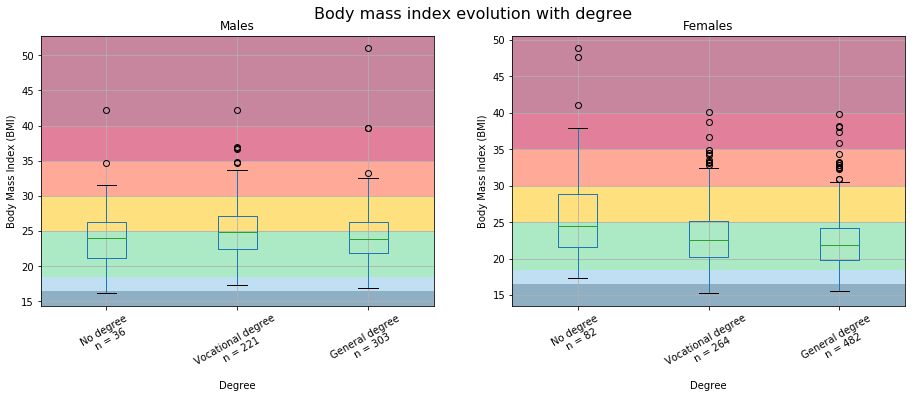

In [43]:
df = dfIndiv[["sexe_ps","poidsm","taille","dip","tage"]]
df["degree"] = (df["dip"]>5)*1+(df["dip"]>8)*1
type_of_degree = ['No degree', 'Vocational degree', 'General degree']
BMI_boxplots(df,"degree",tage=[4,5,6],labels=type_of_degree)

We identify a trend for females: the more advanced degree you have the less likely you are to be overweight. We cannot see this pattern with men but this can be linked to the fact that the first category (male with no degree) has not enough people in it so the results for this category are likely to be very noisy. Indeed if we compare male with vocational degree and male with general degree we see the same kind of pattern than with females. Let's see if it is significant:

In [44]:
test = """p_values for:\n
- males without degree against males with a vocational degree:            {:.3e}
- males without degree against males with a general degree:               {:.3e}
- males with a vocational degree against males with a general degree:     {:.3e}
- females without degree against females with a vocational degree:        {:.3e}
- females without degree against females with a general degree:           {:.3e}
- females with a vocational degree against females with a general degree: {:.3e}
""".format(float(t_test(df, 1, "degree", 0, 1).pvalue),
           float(t_test(df, 1, "degree", 0, 2).pvalue),
           float(t_test(df, 1, "degree", 1, 2).pvalue),
           float(t_test(df, 2, "degree", 0, 1).pvalue),
           float(t_test(df, 2, "degree", 0, 2).pvalue),
           float(t_test(df, 2, "degree", 1, 2).pvalue)
          )
print(test)

p_values for:

- males without degree against males with a vocational degree:            8.664e-02
- males without degree against males with a general degree:               2.732e-01
- males with a vocational degree against males with a general degree:     1.045e-06
- females without degree against females with a vocational degree:        1.074e-02
- females without degree against females with a general degree:           2.113e-09
- females with a vocational degree against females with a general degree: 4.634e-10



Appart from the category "male with no degree" that has to few individual in it, the comparisons are all significant.

#### Food habits

We tried to see if interest in food could have an impact on BMI. However the very small number of persons in some categories does not allow us to draw any clear conclusion.

In [45]:
df = dfIndiv[["sexe_ps","poidsm","taille","intaliform","tage"]].loc[dfIndiv["intaliform"].isin([1,2,3,4])]
interest_labels = ["lot of interest", "some interest", "not a lot of interest"]
BMI_boxplots(df,"intaliform",labels=interest_labels, tage=[4,5,6], category_name="interest in healthy food")

df = dfIndiv[["sexe_ps","poidsm","taille","intaliplais","tage"]].loc[dfIndiv["intaliplais"].isin([1,2,3,4])]
pleasure_labels = ["lot of pleasure", "some pleasure", "not a lot of pleasure"]
BMI_boxplots(df,"intaliplais",labels=pleasure_labels, tage=[4,5,6], category_name="pleasure in eating")

#### BMI evolution with living place

In [46]:
type_of_town = ['Rural', '2,000-20,000\n inhab.', '20,000-100,000\n inhab.', '>100,000\n inhab.', 'Paris']
BMI_boxplots(dfIndiv,"agglo5",labels=type_of_town, tage=[4,5,6],x_label="Type of agglomeration", category_name="living place")

We do not see clear trends. There seems to be a bit less overweight people in very big agglomerations but this trend disappears if we plot the results of just one age category. This is not very surprising as we expect to have more elderly persons in rural areas and have we have seen before, the older the higher the BMI.

Let's look at the difference between regions. In order not to show aberrant values we only plot the average BMI in regions with more than 30 individuals of the gender studied.

In [47]:
def filterRegions(threshold, gender, tage):
    '''
    Returns the regions with more than 40 persons of the given gender.
    '''
    df = dfIndiv[["sexe_ps","poidsm","taille","tage","region"]]
    df = df.loc[(df["tage"].isin(tage))]
    df = df.loc[df["sexe_ps"]==gender][["sexe_ps","region"]].groupby("region").count()
    df_under_th = df.loc[df["sexe_ps"]<threshold]
    NoData = [i for i in df_under_th.index]
    regions_geo_path = "data/regions-avant-redecoupage-2015.geojson"
    geo_json_data = json.load(open(regions_geo_path))
    i = 0
    while i < len(geo_json_data['features']):
        g = geo_json_data['features'][i]['properties']
        if int(g['code']) in NoData:
            del geo_json_data['features'][i]
        else:
            i += 1
    return geo_json_data


def BMI_map(gender, threshold=30, tage=[4,5,6]):
    '''
    Returns the map of the average BMI for individual of the given gender and age.
    Only displays the regions where there are at least 30 individuals in order to have meaningful values.
    '''
    df = dfIndiv[["sexe_ps","poidsm","taille","tage","region"]]
    df = df.loc[(df["tage"].isin(tage))]
    df["imc"]=df["poidsm"]/((df["taille"]/100)**2)
    df_gender = df.loc[df["sexe_ps"]==gender][["imc","region"]].groupby("region").mean()
    df_gender["region"] = df_gender.index
    df_gender["region"] = df_gender["region"].astype(str)
    geo_json_data = filterRegions(threshold=threshold, gender=gender, tage=tage)
    m_france = folium.Map([46.6, 4], zoom_start=5)
    m_france.choropleth(
     geo_data=geo_json_data,
     data=df_gender,
     columns=['region', 'imc'],
     key_on='feature.properties.code',
     fill_color='OrRd',
     fill_opacity=0.7,
     line_opacity=0.7,
     legend_name="Body Mass Index",
    highlight=True
    )
    return m_france

In [48]:
m_france_male = BMI_map(1)
m_france_male

In [49]:
m_france_female = BMI_map(2)
m_france_female

The main problem with this representation is that there are too many regions where we lack data. This is partly due to the fact that we have displayed two maps (one for men and one for women) so we can only use half of the indiviuals of the dataset to display one map or the other.

### Milestone 3: synthesis on BMI

From all what we have seen before we decide to keep 3 elements for our data story: age, diploma and social class. We want to produce interactive boxplots that give extra information on each person. We also have to translate everything in english to make it understandable for non-french speakers.

In [6]:
# Translation of the main columns of the dataframe

dfI = dfIndiv.loc[(dfIndiv["tage"].isin([4,5,6,7,8])) & (dfIndiv["dip"]<13)]
dfI = dfI[["nomen","agglo5","aptotal_hebdo","assis_j","bmi","cspi","v2_age","dip","fastfood","fume","intense_hebdo","poidsm","sexe_ps","taille","tage"]]
indices = []

#living place
category = {1:'rural', 2:'2,000-20,000 inhabitants', 3:'20,000-100,000 inhabitants', 4:'>100,000 inhabitants', 5:'Paris'}
dfI["living place"] = dfI["agglo5"].map(category)

#weekly physical exercise
category = {0:"<4h", 1:"4h-8h", 2:"8h-12h", 3:"12h-16h", 4:"16h-20h", 5:">20h"}
dfI["weekly physical exercise"] = ((dfI["aptotal_hebdo"]>240)*1+(dfI["aptotal_hebdo"]>480)*1+(dfI["aptotal_hebdo"]>720)*1+(dfI["aptotal_hebdo"]>960)*1+(dfI["aptotal_hebdo"]>1200)*1).map(category)

#daily time sitted
category = {0:"<2h", 1:"2h-4h", 2:"4h-6h", 3:"6h-8h", 4:">8h"}
dfI["daily time sitted"] = ((dfI["assis_j"]>120)*1+(dfI["assis_j"]>240)*1+(dfI["assis_j"]>360)*1+(dfI["assis_j"]>480)*1).map(category)

#degree
category = {0:'No degree', 1:'Vocational degree', 2:'General degree'}
dfI["degree"] = ((dfI["dip"]>5)*1+(dfI["dip"]>8)*1).map(category)

#exact degree
category = {
            1:"No degree but read-write", 
            2:"No degree, stop primary school",
            3:"No degree, stop secondary school",
            4:"No degree, stop after secondary school",
            5:"No degree (no further detail)",
            6:"Primary school certificate (CEP)",
            7:"Vocational degree (below baccalauréat)",
            8:"Vocational degree (below baccalauréat)",
            9:"Technical or vocational baccalauréat",
            10:"General baccalauréat",
            11:"Bachelor",
            12:"Master, PhD"
           } 
dfI["exact degree"] = dfI["dip"].map(category)

#fastfood
category = {
            0:"Other answer",
            1:"Almost everyday",
            2:"4-5 days per week",
            3:"2-3 days per week",
            4:"1 day per week",
            5:"1-3 days per month",
            6:"<1 day per month",
            7:"never",
            8:"Other answer",
            9:"Other answer"
}
dfI["fastfood"] = dfI["fastfood"].map(category)

#smoke
category = {
    0:"Other answer",
    1:"Yes, daily",
    2:"Yes, sometimes",
    3:"No, has already smoked",
    4:"No, has never smoked",
    9:"Other answer"
}
dfI["smoke"] = dfI["fume"].map(category)

#weekly intense physical exercise
category = {
    0:"No intense physical exercise",
    1:"<1h",
    2:"1h-2h",
    3:"2h-3h",
    4:">3h"
}
dfI["weekly sport"] = ((dfI["intense_hebdo"]>0)*1+(dfI["intense_hebdo"]>60)*1+(dfI["intense_hebdo"]>120)*1+(dfI["intense_hebdo"]>180)*1).map(category)

#gender
category = {1:"male", 2:"female"}
dfI["gender"] = dfI["sexe_ps"].map(category)

#weight
dfI = dfI.rename(columns={})

#age category
category = {
    4:"18-24 years",
    5:"25-34 years",
    6:"35-49 years",
    7:"50-64 years",
    8:">64 years"
}
dfI["age category"] = dfI["tage"].map(category)

#cspi
category = {
           1:"farmer",
           2:"craftsman, shopkeeper, business owner",
           3:"craftsman, shopkeeper, business owner",
           4:"craftsman, shopkeeper, business owner",
           5:"corporate manager, intellectual",
           6:"corporate manager, intellectual",
           7:"intermediate profession",
           8:"intermediate profession",
           9:"intermediate profession",
          10:"employee",
          11:"worker",
          12:"worker",
          13:"unknown",
          14:"unemployed",
          15:"student",
          16:"retiree",
          17:"retiree",
          18:"not working",
          19:"not working",
          20:"unknown"
}
dfI["social class"] = dfI["cspi"].map(category)

# Translate some column names
dfI = dfI.rename(columns={'taille': 'height', 'poidsm': 'weight', 'v2_age': 'age'})
dfI = dfI[[
    "nomen",
    "bmi",
    "living place",
    "weekly physical exercise",
    "daily time sitted",
    "degree",
    "exact degree",
    "fastfood",
    "smoke",
    "weekly sport",
    "gender",
    "age category",
    "height",
    "weight",
    "age",
    "social class"
]]

In [7]:
dfI.head()

nomen       bmi              living place weekly physical exercise  \
0  110006  31.24524                     rural                   8h-12h   
1  110007  24.22145                     rural                      <4h   
2  110020  33.21799                     rural                      <4h   
3  110021  22.93975  2,000-20,000 inhabitants                      <4h   
4  110025  20.93664  2,000-20,000 inhabitants                    4h-8h   

  daily time sitted             degree  \
0               <2h  Vocational degree   
1             2h-4h  Vocational degree   
2             4h-6h     General degree   
3               >8h          No degree   
4             2h-4h  Vocational degree   

                             exact degree          fastfood  \
0        Primary school certificate (CEP)  <1 day per month   
1  Vocational degree (below baccalauréat)  <1 day per month   
2                    General baccalauréat             never   
3           No degree (no further detail)             never   
4  Vocational degree (below baccalauréat)   Almost everyday   

                    smoke                  weekly sport  gender age category  \
0    No, has never smoked                         1h-2h  female  50-64 years   
1  No, has already smoked  No intense physical exercise    male    >64 years   
2  No, has already smoked  No intense physical exercise  female  35-49 years   
3    No, has never smoked  No intense physical exercise  female    >64 years   
4  No, has already smoked                           <1h  female  35-49 years   

   height  weight  age                     social class  
0   162.0    82.0   54                         employee  
1   170.0    70.0   70                          retiree  
2   170.0    96.0   43  corporate manager, intellectual  
3   152.0    53.0   75                          retiree  
4   165.0    57.0   39                         employee

In [9]:
# Overview of BMI across french adult population

def color(x):
    '''
    Return a color according to the BMI value given: 
    blue for underweight people,
    green for normal BMI,
    orange for overweight people.
    '''
    if(x<18.5):
        return "#375D81"
    if(x>25):
        return "#FFBD4F"
    else:
        return "#8FCF3C"

    
output_notebook()
output_file("outputs/overview_bmi.html")

# Create an interactive histogram
total = len(dfI["bmi"].dropna().astype(float))
hist, edges = np.histogram(dfI["bmi"].dropna().astype(float), bins=40)
x_min = []
x_max = []
for k in range(len(hist)):
    x_min += [edges[k]]
    x_max += [edges[k+1]]

                                                 
source = ColumnDataSource(data=dict(
    x=[(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)],
    color=[color((edges[i]+edges[i+1])/2) for i in range(len(edges)-1)],
    hist = hist/total*100,
    width=[(edges[i+1]-edges[i]) for i in range(len(edges)-1)],
    x_min = x_min,
    x_max = x_max
))

# Labels
TOOLTIPS = [
    ("Percentage of the population", "@hist"+"%"),
    ("(min,max)", "(@x_min,@x_max)"),
]                                                 
                                                 
p = figure(title="BMI distribution of french adults",background_fill_color="#E8DDCB",x_axis_label='BMI',y_axis_label='Percentage of the population')                                                
p.vbar(x='x', top='hist', width='width',line_color="black",color="color", source=source)
p.add_tools(HoverTool(tooltips=TOOLTIPS, mode="vline"))

# Color boxes on background
yrange = [16.5, 18.5, 25, 30, 35, 40]
colors = ['#85c1e9','#58d68d','#FFC300','#FF5733','#C70039']
low_box = BoxAnnotation(right=16.5, fill_alpha=0.2, fill_color='#21618c')
p.add_layout(low_box)
for i in range(len(colors)):
    mid_box = BoxAnnotation(left=yrange[i], right=yrange[i+1], fill_alpha=0.2, fill_color=colors[i])
    p.add_layout(mid_box)
high_box = BoxAnnotation(left=40, fill_alpha=0.2, fill_color='#900C3F')
p.add_layout(high_box)

show(p)
save(p)

Loading BokehJS ...

'C:\\Users\\josep\\Desktop\\EPFL_Courses\\Ada\\ADAX-project\\project\\outputs\\overview_bmi.html'

In [12]:
def outliers(category, dataframe, upper, lower):
    out = []
    for category_value in upper.index:
        dfI = dataframe.loc[dataframe[category]==category_value]
        out += [dfI.loc[(dfI["bmi"]>upper[category_value])|(dfI["bmi"]<lower[category_value])][[category, "bmi"]]]
    out = pd.concat(out)
    return out

def extract_stats(dfI, category, order):
    stats = dfI.groupby(category)['bmi'].describe()
    if(order!=None):
        stats = stats.reindex(order)
    q1 = stats["25%"]
    q2 = stats["50%"]
    q3 = stats["75%"]
    mean = stats["mean"]
    count = stats["count"]
    iqr = q3-q1
    upper = np.minimum(q3 + 1.5*iqr, stats["max"])
    lower = np.maximum(q3 - 1.5*iqr, stats["min"])
    return q1, q2, q3, mean, count, iqr, upper, lower




def boxplot(dfI, category, title="", order=None, file=None):
    if(file==None):
        output_notebook()
    else:
        output_file(file)
    q1, q2, q3, mean, count, iqr, upper, lower = extract_stats(dfI, category, order)
    cats = list(q1.index)
    out = outliers(category, dfI, upper, lower)

    source = ColumnDataSource(data=dict(
        cats=cats,
        upper=upper,
        lower=lower,
        q1=q1,
        q2=q2,
        q3=q3,
        mean=mean,
        count=count,
    ))

    source_points = ColumnDataSource(data=dict(
        cats=dfI[category],
        exact_degree=dfI["exact degree"],
        sexe = dfI["gender"],
        poidsm = dfI["weight"],
        taille = dfI["height"],
        age = dfI["age"],
        social_class = dfI["social class"],
        bmi = dfI["bmi"],
        color = dfI["gender"].map({"male":'#21618c', "female":"#c0392b"})
    ))

    hover = HoverTool(
        tooltips = [
            ("q1", "@q1"),
            ("median", "@q2"),
            ("mean", "@mean"),
            ("q3", "@q3"),
            ("n", "@count"),
            ("category", "@cats")
        ],
        names = ["bar"],
    )

    hover_points = HoverTool(
        tooltips = [
            ("degree", "@exact_degree"),
            ("gender", "@sexe"),
            ("weight", "@poidsm"),
            ("height", "@taille"),
            ("age", "@age"),
            ("social class", "@social_class"),
            ("bmi", "@bmi"),
        ],
        names = ["scatterplot"],
    )

    p = figure(tools="pan,wheel_zoom,box_zoom,reset", x_range=cats, title=title, plot_width=800,y_axis_label='BMI')
    p.add_tools(hover)
    p.add_tools(hover_points)

    #background colors
    yrange = [16.5, 18.5, 25, 30, 35, 40]
    colors = ['#85c1e9','#58d68d','#FFC300','#FF5733','#C70039']
    low_box = BoxAnnotation(top=16.5, fill_alpha=0.2, fill_color='#21618c')
    p.add_layout(low_box)
    for i in range(len(colors)):
        mid_box = BoxAnnotation(bottom=yrange[i], top=yrange[i+1], fill_alpha=0.2, fill_color=colors[i])
        p.add_layout(mid_box)
    high_box = BoxAnnotation(bottom=40, fill_alpha=0.2, fill_color='#900C3F')
    p.add_layout(high_box)

    #outliers
    p.cross(out[category], out["bmi"], size=6, color="#F38630", legend='boxplot')
    #stems
    p.segment('cats', 'upper', 'cats', 'q3', line_color="black", source=source, legend='boxplot')
    p.segment('cats', 'lower', 'cats', 'q1', line_color="black", source=source, legend='boxplot')
    # boxes
    p.vbar('cats', 0.7, 'q2', 'q3', name="bar", fill_color="#E08E79", line_color="black", source=source, legend='boxplot')
    p.vbar('cats', 0.7, 'q1', 'q2', name="bar", fill_color="#3B8686", line_color="black", source=source, legend='boxplot')
    # whiskers (almost-0 height rects simpler than segments)
    p.rect('cats', 'lower', 0.2, 0.01, line_color="black", source=source, legend='boxplot')
    p.rect('cats', 'upper', 0.2, 0.01, line_color="black", source=source, legend='boxplot')



    p.legend.click_policy="hide"
    scatterplot = p.circle(x=jitter('cats', width=0.6, range=p.x_range), y='bmi', size=6, color="color", fill_alpha=0.6, legend='scatterplot', name="scatterplot", source=source_points)
    scatterplot.visible = False
    
    if(file==None):
        show(p)
    else:
        save(p)

In [13]:
boxplot(dfI, "age category", "Body Mass Index according to age", file="outputs/age.html")

In [14]:
boxplot(dfI, "degree", "Body Mass Index according to degree", order=["No degree", "Vocational degree", "General degree"],file="outputs/diploma.html")

In [8]:
# We restrict ourselves to categories where there are enough people to have significant values
df_social = dfI.loc[(dfI["social class"].isin(["worker", "student", "retiree", "intermediate profession", "corporate manager, intellectual"]))]
boxplot(df_social, "social class", "Body Mass Index according to social class", order=["student","corporate manager, intellectual","intermediate profession", "worker", "retiree"], file="outputs/social_class.html")

### Tobacco consumption with living place

We can make the choice to gather men and women and to display only one map, for instance a map displaying tobacco consumption.

In [50]:
def filterRegions(dataframe, threshold, category, tage):
    '''
    Returns the regions with more than 40 persons.
    '''
    df = dataframe[[category,"tage","region"]]
    df = df.loc[(df["tage"].isin(tage))]
    df = df[[category,"region"]].groupby("region").count()
    df_under_th = df.loc[df[category]<threshold]
    NoData = [i for i in df_under_th.index]
    regions_geo_path = "data/regions-avant-redecoupage-2015.geojson"
    geo_json_data = json.load(open(regions_geo_path))
    i = 0
    while i < len(geo_json_data['features']):
        g = geo_json_data['features'][i]['properties']
        if int(g['code']) in NoData:
            del geo_json_data['features'][i]
        else:
            i += 1
    return geo_json_data


def Category_map(dataframe, category, legend, threshold=30, tage=[4,5,6,7,8]):
    '''
    Returns the map of the average value of the studied category for individual of the given age.
    Only displays the regions where there are at least 30 individuals in order to have meaningful values.
    '''
    df = dataframe[[category,"tage","region"]]
    df = df.loc[(df["tage"].isin(tage))]
    df = df.groupby("region").mean()
    df["region"] = df.index
    df["region"] = df["region"].astype(str)
    geo_json_data = filterRegions(dataframe, threshold, category, tage)
    m_france = folium.Map([46.6, 4], zoom_start=5)
    m_france.choropleth(
     geo_data=geo_json_data,
     data=df,
     columns=['region', category],
     key_on='feature.properties.code',
     fill_color='PuRd',
     fill_opacity=0.7,
     line_opacity=0.7,
     legend_name=legend,
     highlight=True
    )
    return m_france

In [51]:
df = dfIndiv.loc[(dfIndiv["fume"].isin([1,2,3,4]))]
df["tobacco"] = (df["fume"]<3)*1
m_france = Category_map(df,"tobacco","Proportion of smokers")
m_france

### Nutrition and age

In [19]:
def plotMeanValues(table, features, className, mincount=50):
    """
    Plot a normalized stacked bar chart of mean values of each features in features for each class according to 
    class name. Consider only classes with at least mincount elements.
    """
    featuresNames = mapDescription(features)

    means = table.groupby(className).filter(lambda x: len(x) > mincount).groupby(className).mean()[features]
    means.columns = featuresNames
    means /= means.sum(axis=0)
    means = means.swapaxes(0, 1)
    means.columns = mapCorrespondances(means.columns, className)
    means.plot.bar(stacked=True, width=1, figsize=FIG_SIZE)
    plt.show()
    

    


In [20]:
indnutIndTable = dfIndnut.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")
columns = {col:col[:-2] for col in indnutIndTable.columns if col[-2:] == "_x"}
dropColumns = [col for col in indnutIndTable.columns if col[-2:] == "_y"]
indnutIndTable = indnutIndTable.rename(columns = columns).drop(columns= dropColumns)
numFeatures = ["nutj{}".format(i) for i in range(4, 29)] + ["nutj{}".format(i) for i in range(30, 40)]# + ["poidsm", "taille", "v2_age", "tele", "intense_j", "modere_j", "marche_j"]

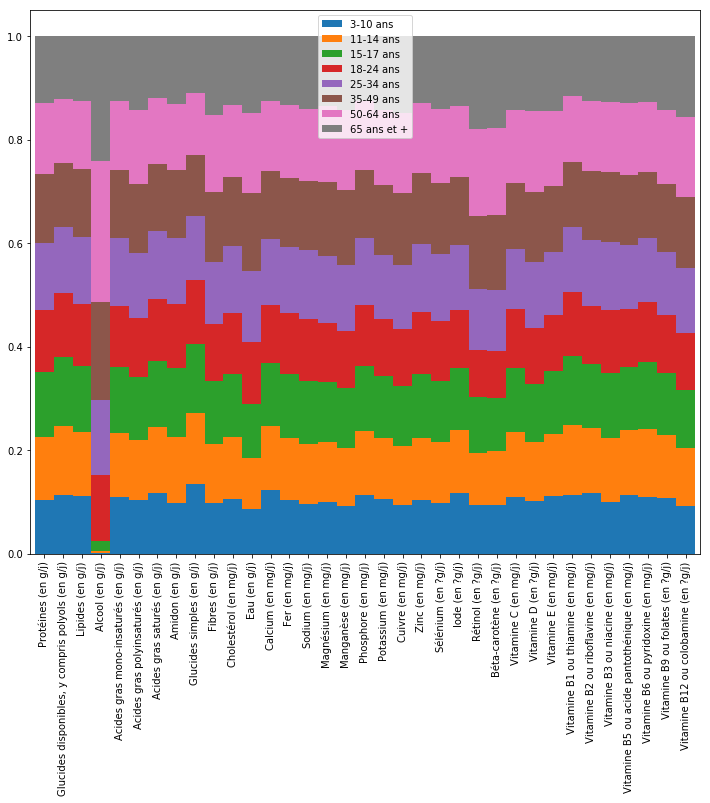

In [21]:
plotMeanValues(indnutIndTable, numFeatures, "tage")

Here we obtain interesting results that the consumption of nutriments depends a lot of the age. Alcohol especially but also Calcium, Retinol and Beta-carotene. The older people seem to consume overall more than the younger age classes. That must be linked withthe fact that they have a greater BMI than the younger ones. But is there a causality relation or is it only a corrleation will require further investigation.

### CSP Effect

Just consider the distrubution of people in the different categories will give us an insight of the relevance of our data.

In [9]:
# These feature are a set use to explore a wide part of the data
nutritionFeatures = ["nutj{}".format(i) for i in range(4, 29)]\
            + ["nutj{}".format(i) for i in range(30, 40)]\
            + ["bmi", "intense_j", "modere_j", "marche_j"]

df_social2 = dfI.loc[(dfI["social class"].isin(["worker", "student", "retiree", "intermediate profession", "corporate manager, intellectual", "employee", "craftsman, shopkeeper, business owner"]))]

category = {
           "farmer":"farmer",
           "craftsman, shopkeeper, business owner":"craftsman,\nshopkeeper,\nbusiness owner",
           "corporate manager, intellectual":"corporate\nmanager,\nintellectual",
           "intermediate profession":"intermediate\nprofession",
           "employee":"employee",
           "worker":"worker",
           "student":"student",
           "retiree":"retiree",

}
df_social2["social class"] = df_social2["social class"].map(category)

df_social2.head()

nomen       bmi              living place weekly physical exercise  \
0  110006  31.24524                     rural                   8h-12h   
1  110007  24.22145                     rural                      <4h   
2  110020  33.21799                     rural                      <4h   
3  110021  22.93975  2,000-20,000 inhabitants                      <4h   
4  110025  20.93664  2,000-20,000 inhabitants                    4h-8h   

  daily time sitted             degree  \
0               <2h  Vocational degree   
1             2h-4h  Vocational degree   
2             4h-6h     General degree   
3               >8h          No degree   
4             2h-4h  Vocational degree   

                             exact degree          fastfood  \
0        Primary school certificate (CEP)  <1 day per month   
1  Vocational degree (below baccalauréat)  <1 day per month   
2                    General baccalauréat             never   
3           No degree (no further detail)             never   
4  Vocational degree (below baccalauréat)   Almost everyday   

                    smoke                  weekly sport  gender age category  \
0    No, has never smoked                         1h-2h  female  50-64 years   
1  No, has already smoked  No intense physical exercise    male    >64 years   
2  No, has already smoked  No intense physical exercise  female  35-49 years   
3    No, has never smoked  No intense physical exercise  female    >64 years   
4  No, has already smoked                           <1h  female  35-49 years   

   height  weight  age                       social class  
0   162.0    82.0   54                           employee  
1   170.0    70.0   70                            retiree  
2   170.0    96.0   43  corporate\nmanager,\nintellectual  
3   152.0    53.0   75                            retiree  
4   165.0    57.0   39                           employee

In [18]:
def nutritionPlotAllMeans(className, features = nutritionFeatures, mincount=30):
    """
    For each feature, plot the daily consumption, using className to separate the indiduals in different groups.
    """
    # Create a table with the relevent informations, and then group it by className
    table = dfIndnut.merge(dfIndivO18, left_on="nomen", right_on="nomen", how="inner")
    featuresNames = mapDescription(features)
    means = table.groupby(className).filter(lambda x: len(x) > mincount).groupby(className).mean()[features]
    means.columns = featuresNames
    # print a table to help interpreting the plot (NEED TO BE IMPROVED)
    print(dfDataCorrespondance[dfDataCorrespondance["Nom de la variable"] == className][["code", "Signification"]])
    # means.columns = mapCorrespondances(means.columns, className)
    # Plot settings
    nb_col = 2
    nb_rows = len(featuresNames)//nb_col + len(featuresNames)%nb_col
    fig, axes = plt.subplots(nrows=nb_rows, ncols=nb_col, figsize = (nb_col*8, nb_rows*6))
    i = 0
    # Plot each feat
    for feat in features:
        featName = findDescription(feat)
        means[featName].plot(kind='barh', ax = axes[i//nb_col, i%nb_col], label = '')
        axes[i//nb_col, i%nb_col].set_title(featName)
        # add the reference values
        if feat in dfValRef["Nom de la variable"].values:
            refH = dfValRef[dfValRef["Nom de la variable"] == feat]["ValRef_homme"].values[0]
            refF = dfValRef[dfValRef["Nom de la variable"] == feat]["ValRef_femme"].values[0]
            if str(refH) != 'nan':
                ref = 0.5*refH + 0.5*refF
                axes[i//nb_col, i%nb_col].plot([ref, ref],[-10,+10], 'g--', label=('Reference Value (both genders)'))
            else:
                axes[i//nb_col, i%nb_col].plot([0, 0],[0,0], 'g--', label=('No reference available'))
        else:
            axes[i//nb_col, i%nb_col].plot([0, 0],[0,0], 'g--', label=('No reference available'))
        axes[i//nb_col, i%nb_col].legend(loc = 1)
        # Increment i to plot in the next frame
        i += 1
    # Display
    plt.tight_layout()
    plt.show()

    
def nutritionPlotAllMeansGenders(className, features = nutritionFeatures, mincount=10):
    """
    The same as the previous function but split the className category by gender.
    """
    # Create a table with the relevent informations, and then group it by className and "sexeps"
    table = dfIndnut.merge(dfIndivO18, left_on="nomen", right_on="nomen", how="inner")
    featuresNames = mapDescription(features)
    means = table.groupby(["sexeps", className]).filter(lambda x: len(x) > mincount).groupby(["sexeps", className]).mean()[features]
    means.columns = featuresNames
    # print tables to help interpreting the plot (NEED TO BE IMPROVED)
    print(dfDataCorrespondance[dfDataCorrespondance["Nom de la variable"] == "sexeps"][["code", "Signification"]])
    print(dfDataCorrespondance[dfDataCorrespondance["Nom de la variable"] == className][["code", "Signification"]])
    nb_col = 2
    nb_rows = len(featuresNames)//nb_col + len(featuresNames)%nb_col
    fig, axes = plt.subplots(nrows=nb_rows, ncols=nb_col, figsize = (nb_col*8, nb_rows*6))
    i = 0
    # Plot each feat
    for feat in features:
        featName = findDescription(feat)
        means[featName].plot(kind='barh', ax = axes[i//nb_col, i%nb_col], label = '')
        axes[i//nb_col, i%nb_col].set_title(featName)
        # add the reference values
        if feat in dfValRef["Nom de la variable"].values:
            refH = dfValRef[dfValRef["Nom de la variable"] == feat]["ValRef_homme"].values[0]
            refF = dfValRef[dfValRef["Nom de la variable"] == feat]["ValRef_femme"].values[0]
            if str(refH) != 'nan':
                axes[i//nb_col, i%nb_col].plot([refH, refH],[-20,+20], 'r-', label=('Reference Value (men)'))
                axes[i//nb_col, i%nb_col].plot([refF, refF],[-20,+20], 'b--', label=('Reference Value (women)'))
            else:
                axes[i//nb_col, i%nb_col].plot([0, 0],[0,0], 'g--', label=('No reference available'))
        else:
            axes[i//nb_col, i%nb_col].plot([0, 0],[0,0], 'g--', label=('No reference available'))
        axes[i//nb_col, i%nb_col].legend(loc = 1)
        i += 1
    plt.tight_layout()
    plt.show()

def countDistribution(df, className):
    count = df[[className]].groupby(className)\
                           .agg({className:"count"})
    count.index = mapCorrespondances(count.index, className)
    print(count)

countDistribution(dfIndivO18, 'cspi2')
countDistribution(dfIndivO18, 'agglo9')
countDistribution(dfIndivO18, 'tage')

                                        cspi2
agriculteur                                37
artisan, commerçant, chef d'entreprise     99
cadre, prof. int. sup.                    211
profession intermédiaire                  430
employé                                   587
ouvrier                                   316
retraité                                  550
inactif                                   393
                        agglo9
rural                      617
2 000 à 5 000 hab.         175
5 000 à 10 000 hab.        158
10 000 à 20 000 hab.       110
20 000 à 50 000 hab.       132
50 000 à 100 000 hab.      215
100 000 à 200 000 hab.     390
> 200 000 hab.             509
agglo paris                317
             tage
18-24 ans     257
25-34 ans     432
35-49 ans     836
50-64 ans     750
65 ans et +   348


If we have more than 100 people in each geographical category and age bin, this is not the case for socioprofessional categories, where the number of farmers is low (and the female farmers should be even lower). We should keep that in mind when using those categories later.

*

Let's consider some basic nutrients: carbohydrates (glucides), fat (lipides), fibres and water (eau). Let's also add alcohol to the list.

      code Signification
2973     1         homme
2974     2         femme
      code                           Signification
3158     0                                   refus
3159     1                             agriculteur
3160     2  artisan, commerçant, chef d'entreprise
3161     3                  cadre, prof. int. sup.
3162     4                profession intermédiaire
3163     5                                 employé
3164     6                                 ouvrier
3165     7                                retraité
3166     8                                 inactif


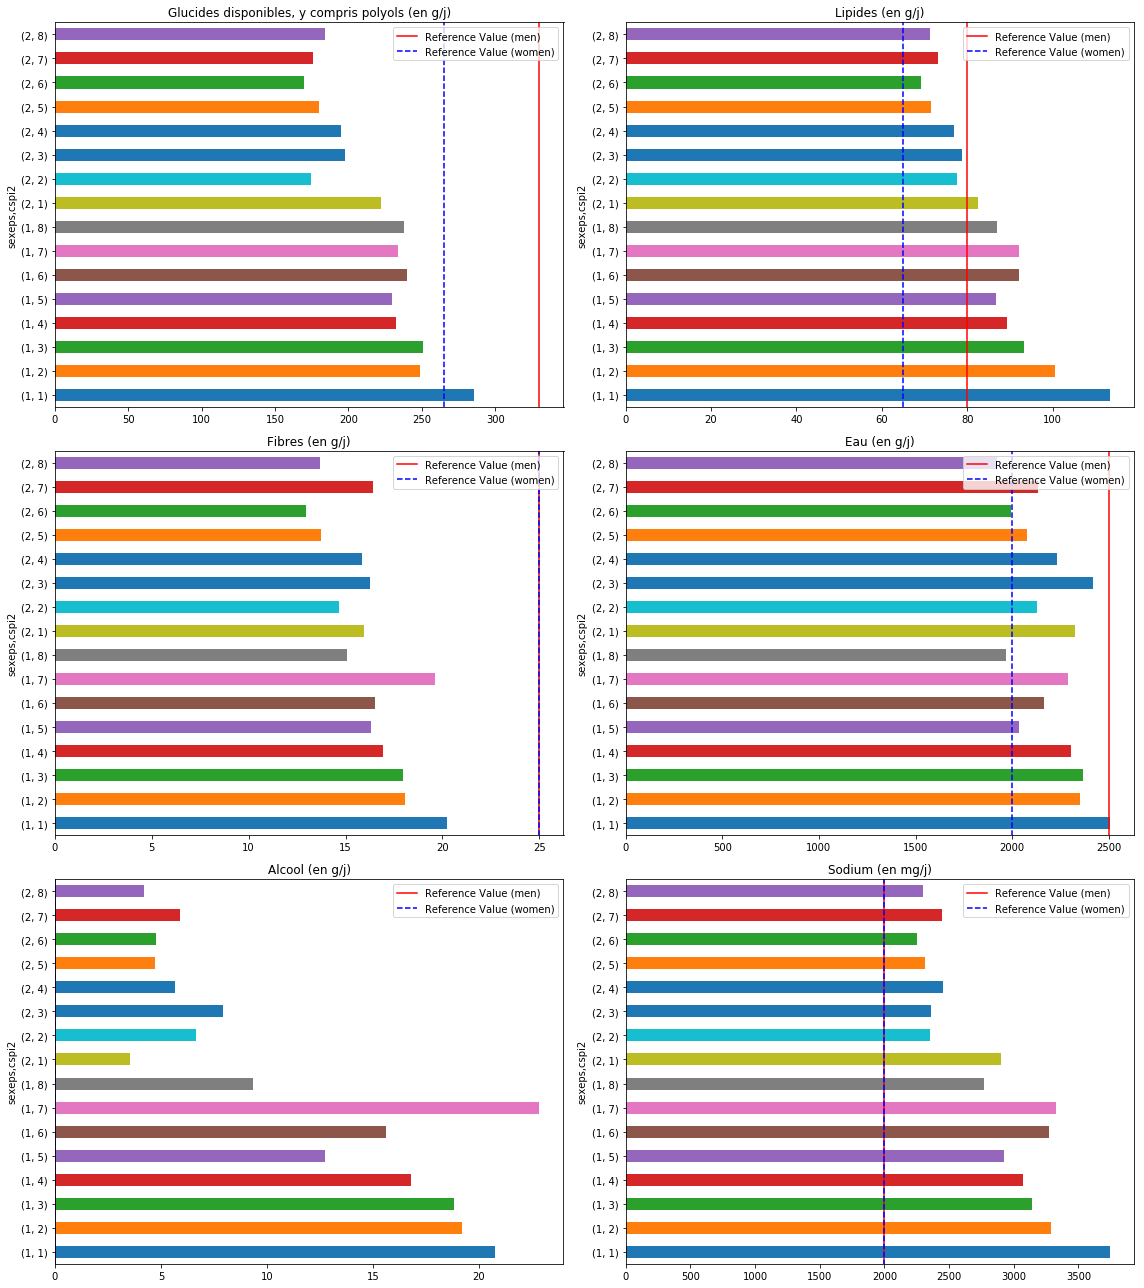

In [20]:
nutritionPlotAllMeansGenders('cspi2', ['nutj5', 'nutj6', 'nutj13', 'nutj15', 'nutj7', 'nutj18'])

Those plot do not shows an important disparity among socioprofessional categories, but are interestng nevertheless. Globally, the share of the energety uptakes coming from fat is too high, and the share coming from carbohydrates is too low.

Moreover everyone in the population lacks fibers. Eventually women and men drinks approximately identical amount of water, but men have higher needs in water ; and the alcohol consumsion is also very gender-dependant.

*

An other factor that we should have in mind when comparing socioprofessional categories is that in fact they should have different needs according to the amount of physical activity involved in their work. The plots below shows that industry workers and farmers do a LOT more physical activity than the other groups.

      code Signification
2973     1         homme
2974     2         femme
      code                           Signification
3158     0                                   refus
3159     1                             agriculteur
3160     2  artisan, commerçant, chef d'entreprise
3161     3                  cadre, prof. int. sup.
3162     4                profession intermédiaire
3163     5                                 employé
3164     6                                 ouvrier
3165     7                                retraité
3166     8                                 inactif


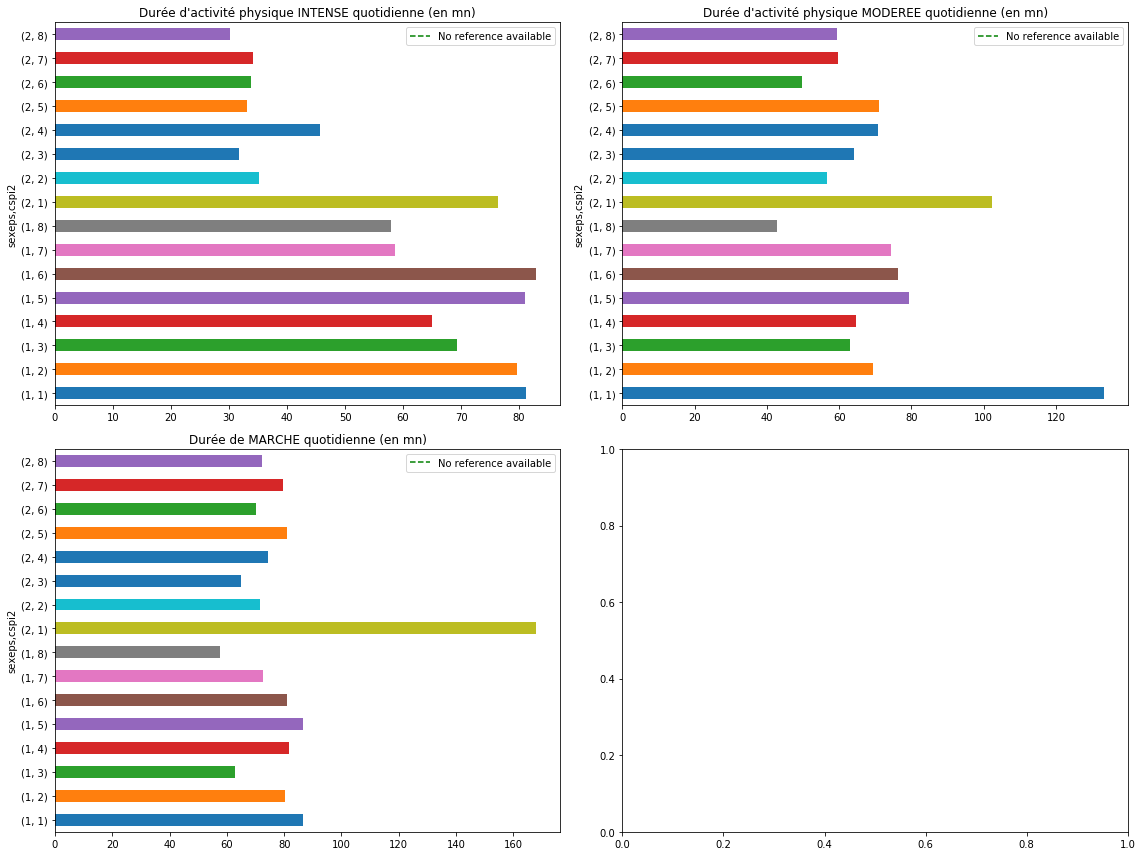

In [17]:
nutritionPlotAllMeansGenders('cspi2', ["intense_j", "modere_j", "marche_j"])

Let's consider the vitamines uptakes, which are the nutritients with the most inequal distribution.

      code Signification
2973     1         homme
2974     2         femme
      code                           Signification
3158     0                                   refus
3159     1                             agriculteur
3160     2  artisan, commerçant, chef d'entreprise
3161     3                  cadre, prof. int. sup.
3162     4                profession intermédiaire
3163     5                                 employé
3164     6                                 ouvrier
3165     7                                retraité
3166     8                                 inactif


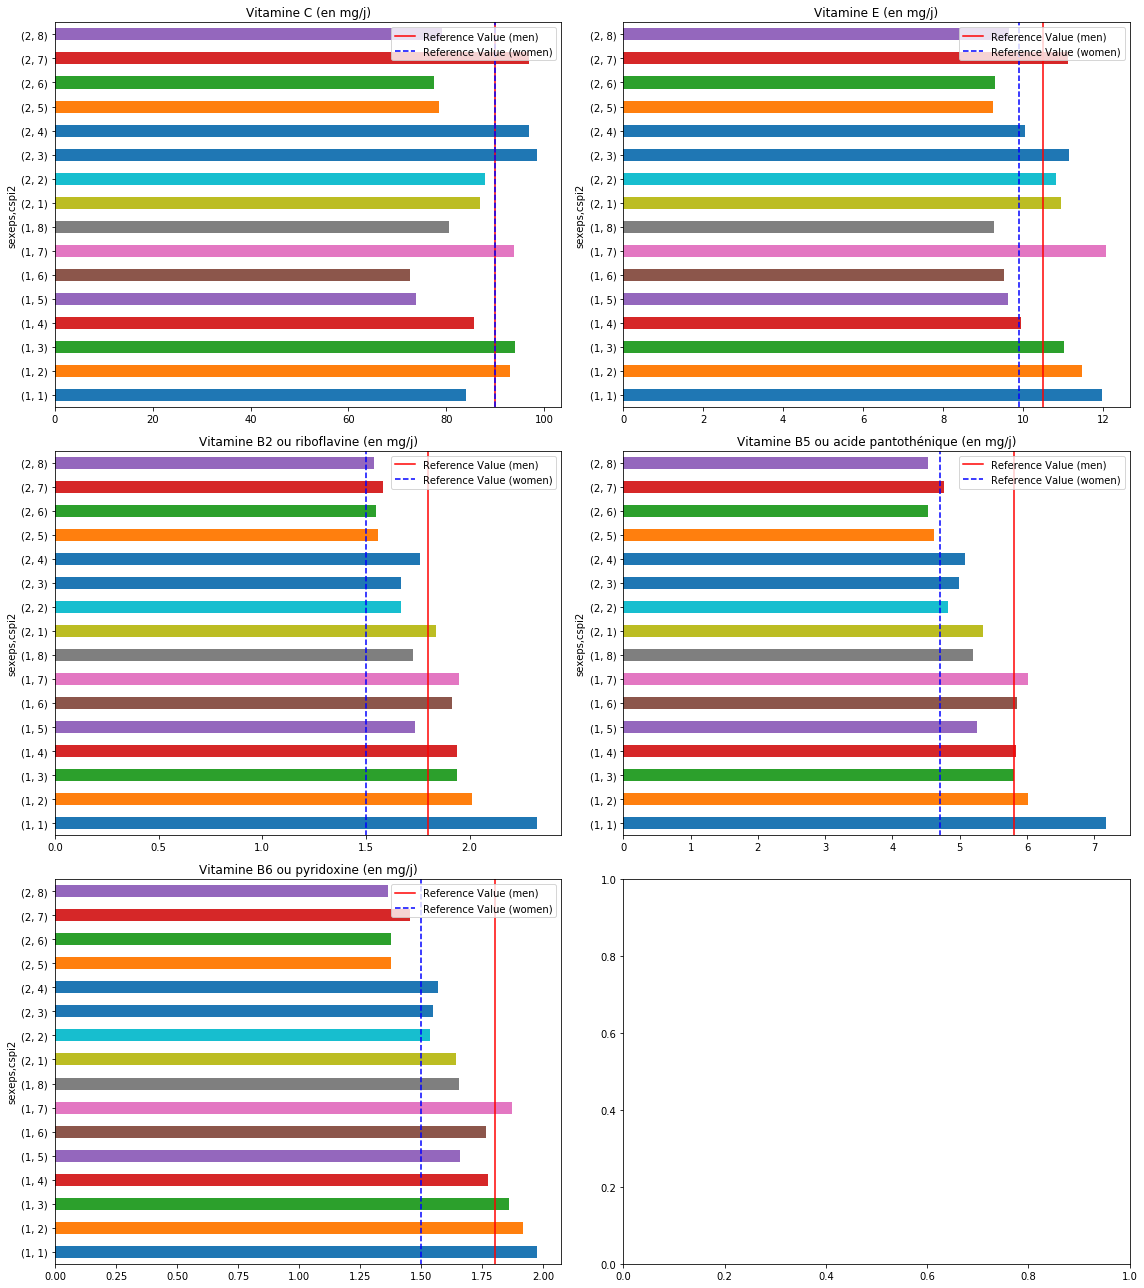

In [18]:
nutritionPlotAllMeansGenders('cspi2', ['nutj30', 'nutj32', 'nutj34', 'nutj36', 'nutj37'])

Some categories (industry workers, employees, inactive people) are often below the thresholds for vitamines. It would be interesting (and not that difficult) to investigate the kind of food that provide those vitamines and why some groups don't have access to those.

### Milestone 3

In [10]:
def plotNutrient(feature, className = "social class", dfSource = df_social2, title = None, sort=True, xlabel = 'g / day'):
    table = dfIndnut.merge(dfSource, left_on="nomen", right_on="nomen", how="inner")
    featureName = findDescription(feature)
    means = table.groupby(["gender", className]).mean()[feature]
    means.columns = [featureName]
    if title == None:
        title = featureName

    index = means.loc["female"].index.values
    female_means = np.transpose(means.loc["female"].values)
    male_means = np.transpose(means.loc["male"].values)


    # Sort by female_means
    if sort:
        idx = female_means.argsort()
        index, female_means, male_means = [np.take(x, idx) for x in [index, female_means, male_means]]
        
    y = np.arange(female_means.size)

    fig, axes = plt.subplots(figsize = (16,7), ncols=2, sharey=True)
    axes[0].barh(y, female_means, align='center', color='#75bbfd', linewidth = 1, edgecolor = 'k', zorder=10)
    axes[0].set_title('Females', fontsize = 14)
    axes[1].barh(y, male_means, align='center', color='#f97306', linewidth = 1, edgecolor = 'k', zorder=10)
    axes[1].set_title('Males', fontsize = 14)

    axes[0].invert_xaxis()
    axes[0].set(yticks=y, yticklabels=index)
    axes[0].yaxis.tick_right()
    axes[0].yaxis.set_tick_params(labelsize=12)

    axes[0].xaxis.set_tick_params(labelsize=12)
    axes[0].set_xlabel(xlabel, fontsize=14)
    axes[1].xaxis.set_tick_params(labelsize=12)
    axes[1].set_xlabel(xlabel, fontsize=14)
    fig.suptitle(title, fontsize=18)

    if feature in dfValRef["Nom de la variable"].values:
        refH = dfValRef[dfValRef["Nom de la variable"] == feature]["ValRef_homme"].values[0]
        refF = dfValRef[dfValRef["Nom de la variable"] == feature]["ValRef_femme"].values[0]
        if str(refH) != 'nan':
            axes[1].plot([refH, refH],[-0.8,-0.2+len(index)], 'k--', label=('Reference Value'), linewidth=3, zorder=11)
            axes[0].plot([refF, refF],[-0.8,-0.2+len(index)], 'k--', label=('Reference Value'), linewidth=3, zorder=11)
        else:
            axes[0].plot([0, 0],[0,0], 'k--', label=('No reference available'))
            axes[1].plot([0, 0],[0,0], 'k--', label=('No reference available'))
    else:
        axes[0].plot([0, 0],[0,0], 'k--', label=('No reference available'))
        axes[1].plot([0, 0],[0,0], 'k--', label=('No reference available'))
    axes[0].legend(loc = 3)
    axes[1].legend(loc = 4)

    for ax in axes.flat:
        ax.margins(0.03)
        ax.grid(True)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    plt.show()

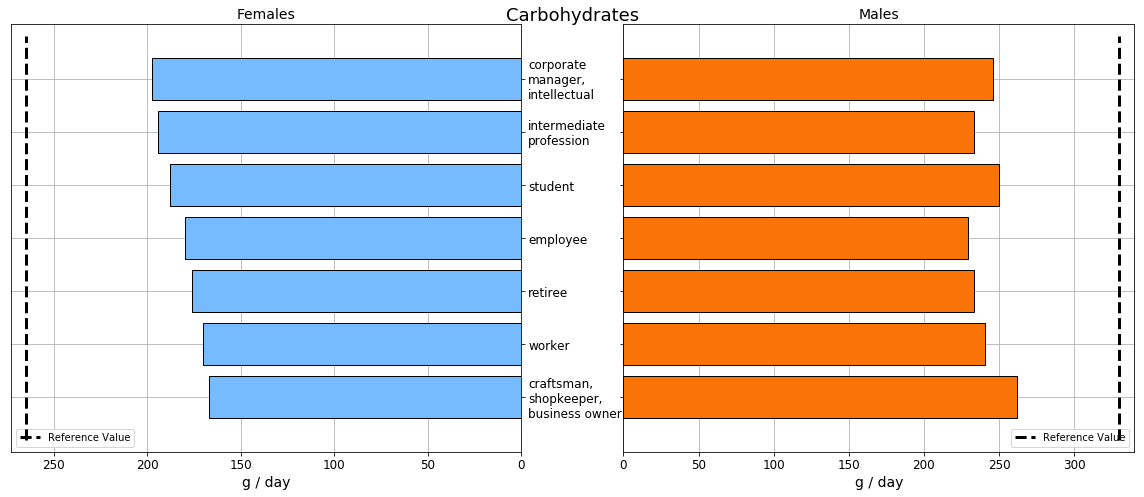

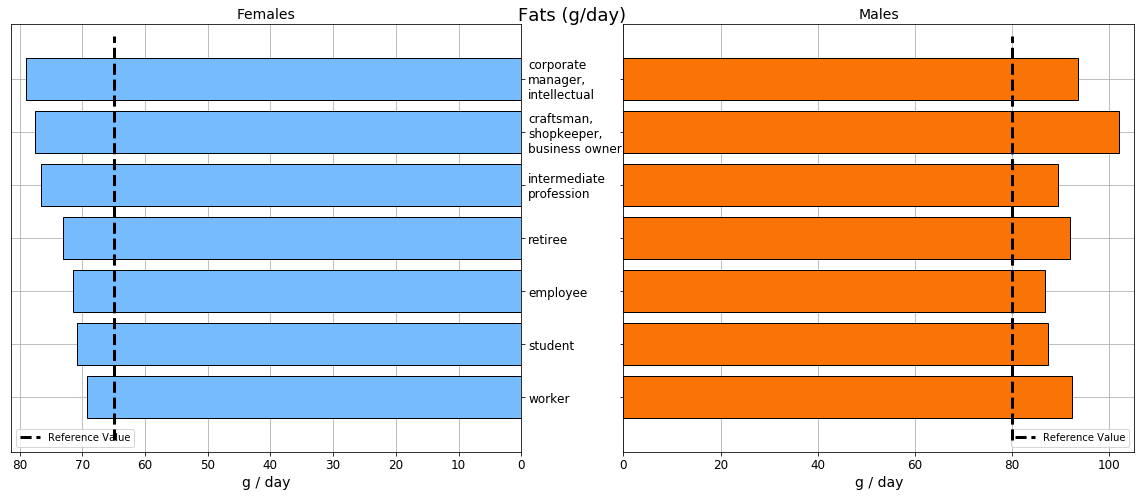

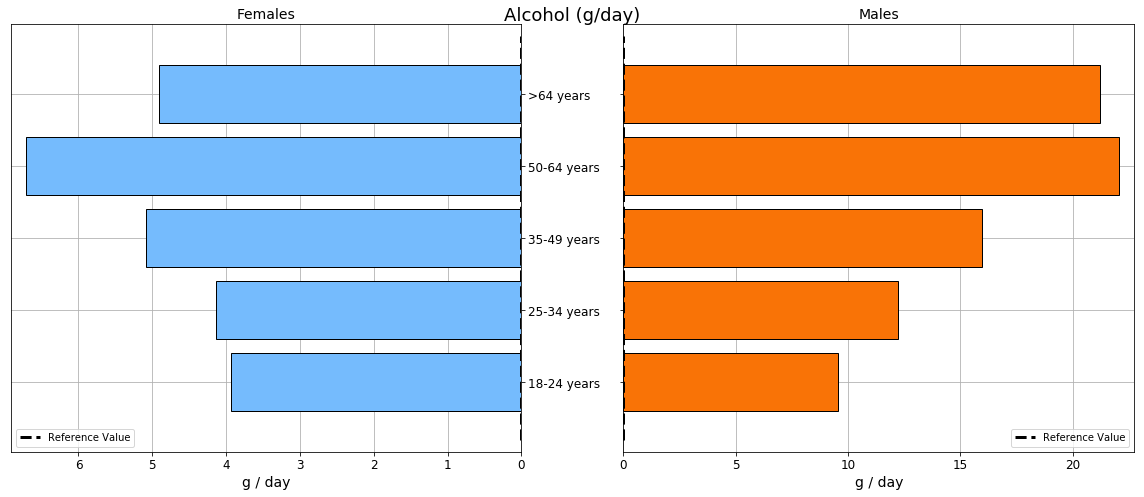

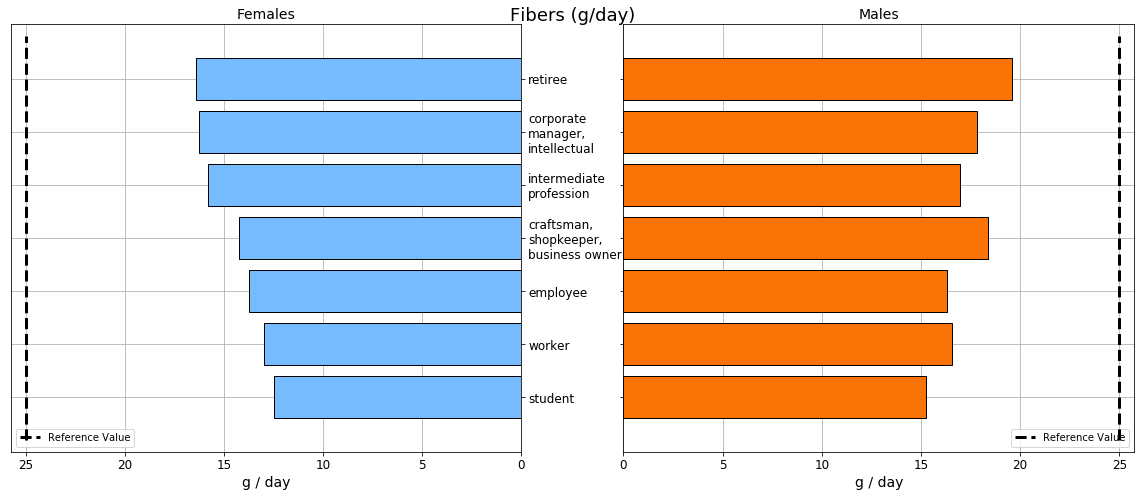

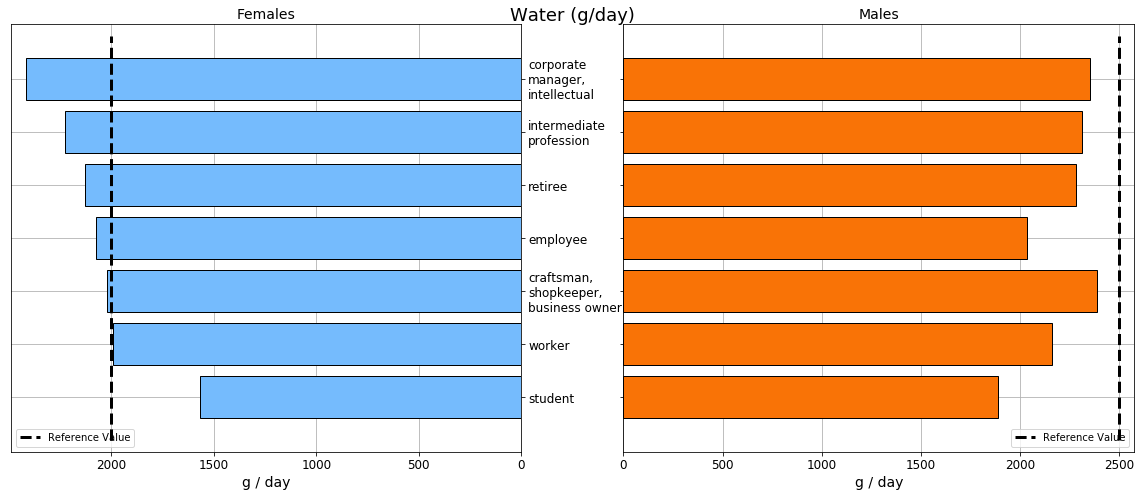

In [15]:
plotNutrient("nutj5", className = "social class", title="Carbohydrates") #glucides
# plotNutrient("nutj5", className = "age category", dfSource = dfI, sort = False, title="Carbohydrates (g/day)") #glucides
plotNutrient("nutj6", className = "social class", title="Fats (g/day)") #lipides
plotNutrient("nutj7", className = "age category", dfSource = dfI, sort = False, title="Alcohol (g/day)") #alcohol

plotNutrient("nutj13", className = "social class", title="Fibers (g/day)") #fibers
plotNutrient("nutj15", className = "social class", title="Water (g/day)") #water



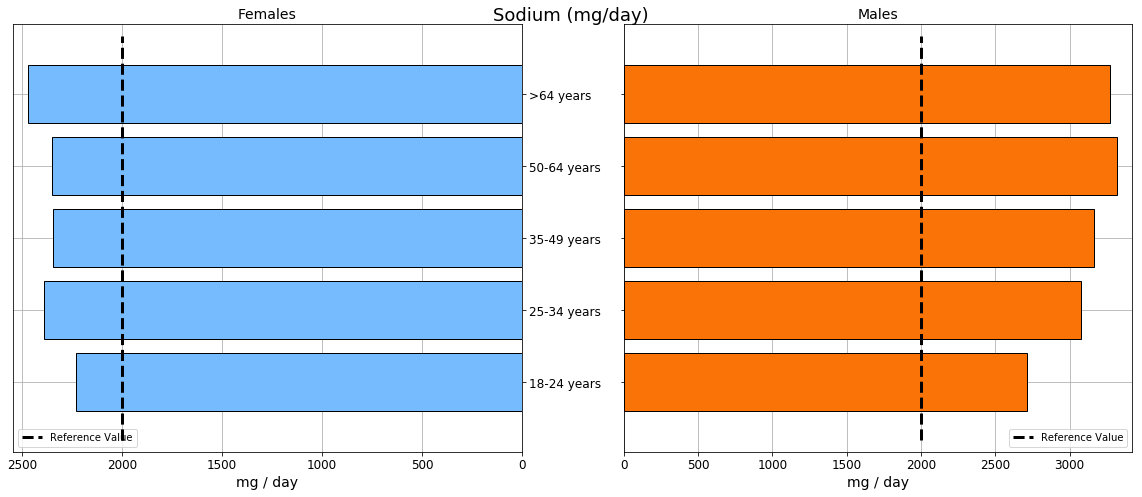

In [21]:
plotNutrient("nutj18", className = "age category", dfSource = dfI, sort = False, title="Sodium (mg/day)", xlabel = "mg / day")

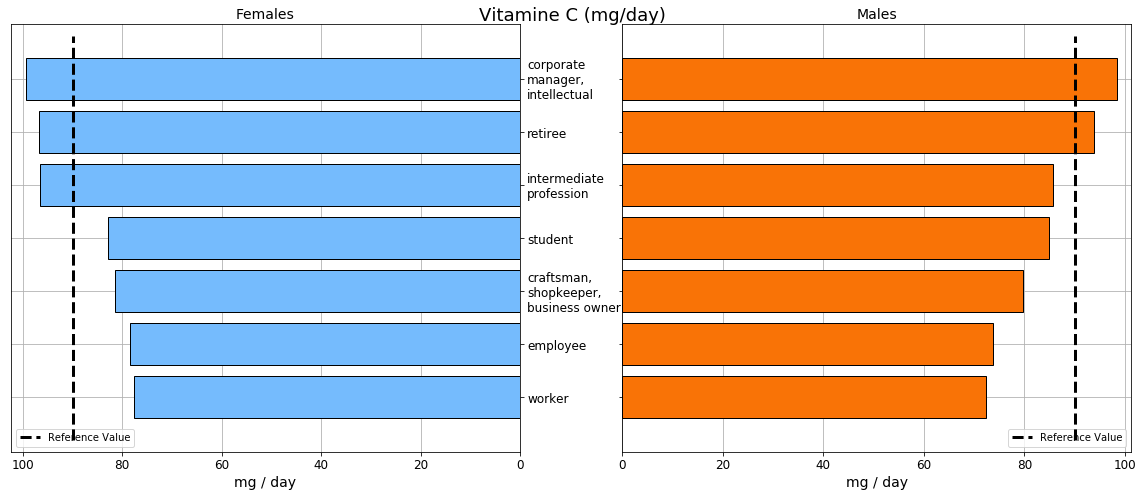

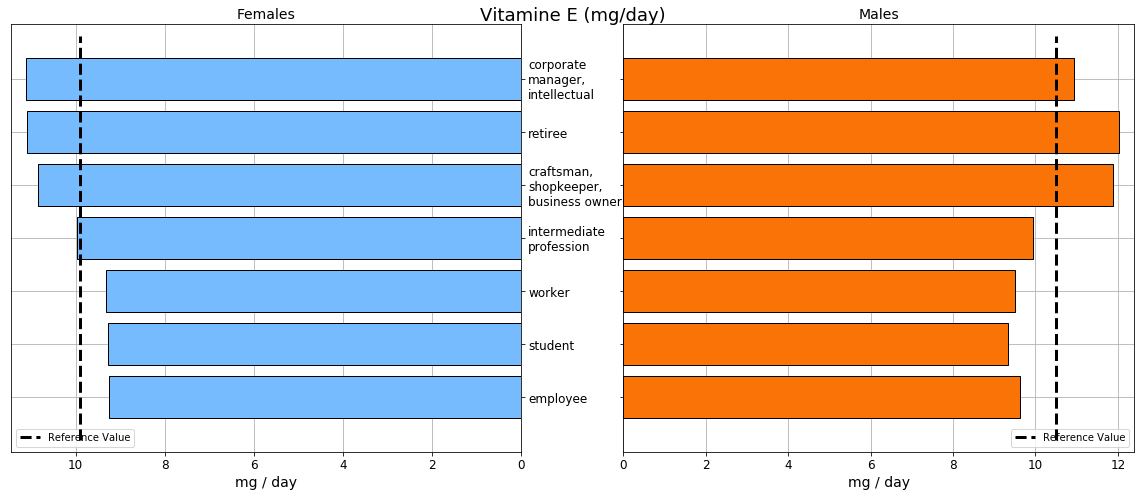

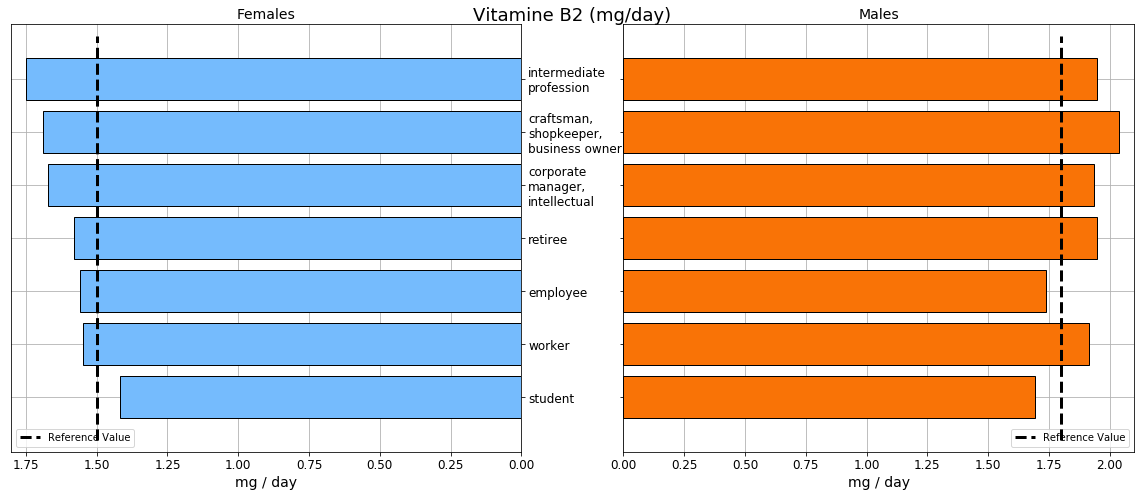

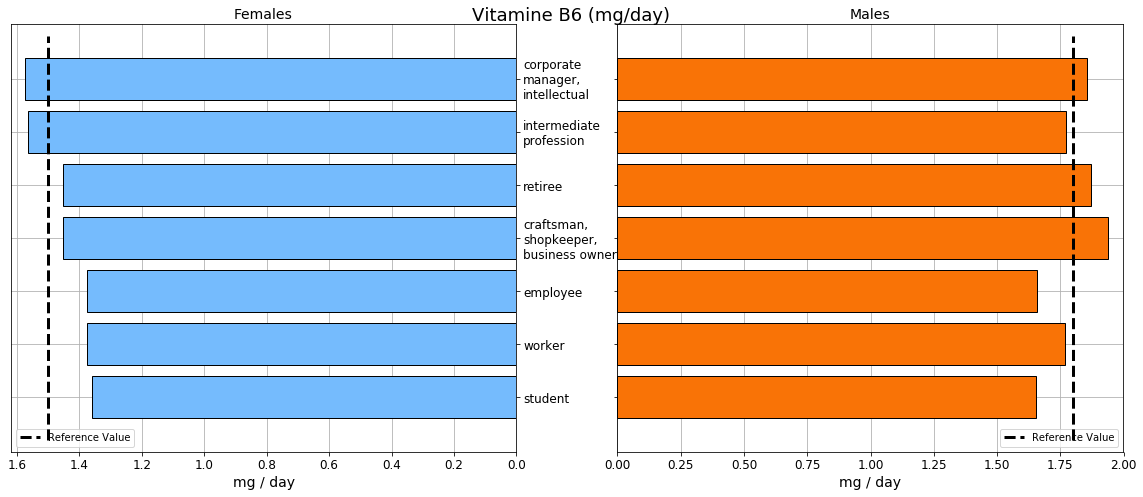

In [16]:
plotNutrient("nutj30", className = "social class", title="Vitamine C (mg/day)", xlabel = "mg / day") #C
plotNutrient("nutj32", className = "social class", title="Vitamine E (mg/day)", xlabel = "mg / day") #E
plotNutrient("nutj34", className = "social class", title="Vitamine B2 (mg/day)", xlabel = "mg / day") #B2
plotNutrient("nutj37", className = "social class", title="Vitamine B6 (mg/day)", xlabel = "mg / day") #B6

       sexeps
homme    1082
femme    1532


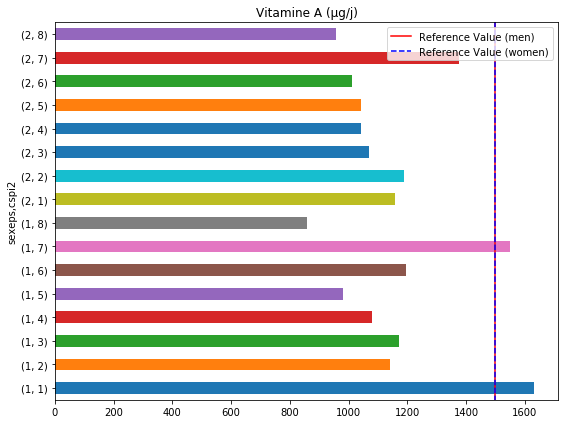

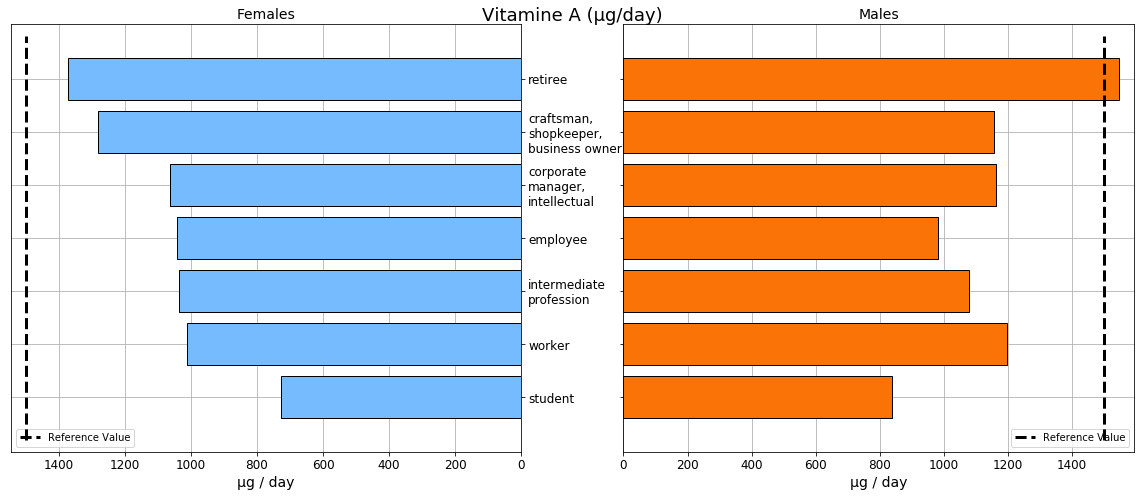

In [19]:
# Code for Vitamine A
# Plot 1
className = 'cspi2'

table = dfIndnut.merge(dfIndivO18[dfIndivO18["sexeps"].apply(lambda x : x in [1, 2] )], left_on="nomen", right_on="nomen", how="inner")
table["nutj27-28"] = table["nutj27"] + table["nutj28"]/6
features = ["nutj27-28"]
featuresNames = ["Vitamine A (µg/j)"]
means = table.groupby(["sexeps", className]).mean()[features]
countDistribution(table, 'sexeps')
means.columns = featuresNames

fig, axes = plt.subplots(1, 1, figsize = (8, 6))
refH = dfValRef[dfValRef["Nom de la variable"] == "nutj27"]["ValRef_homme"].values[0] + dfValRef[dfValRef["Nom de la variable"] == "nutj28"]["ValRef_homme"].values[0]/6
refF = dfValRef[dfValRef["Nom de la variable"] == "nutj27"]["ValRef_femme"].values[0] + dfValRef[dfValRef["Nom de la variable"] == "nutj28"]["ValRef_femme"].values[0]/6
axes.plot([refH, refH],[-20,+20], 'r-', label=('Reference Value (men)'))
axes.plot([refF, refF],[-20,+20], 'b--', label=('Reference Value (women)'))
means[featuresNames[0]].plot(kind='barh', ax = axes, label = '')
axes.set_title(featuresNames[0])
axes.legend(loc = 1)

plt.tight_layout()
plt.show()

# Plot 2

feature = "nutj27-28"
className = "social class"
dfSource = df_social2
title = None
sort=True

dfIndnut_2 = dfIndnut.copy()
dfIndnut_2["nutj27-28"] = dfIndnut_2["nutj27"] + dfIndnut_2["nutj28"]/6
table = dfIndnut_2.merge(dfSource, left_on="nomen", right_on="nomen", how="inner")
featureName = "Vitamine A (µg/day)"
means = table.groupby(["gender", className]).mean()[feature]
means.columns = [featureName]
if title == None:
    title = featureName

index = means.loc["female"].index.values
female_means = np.transpose(means.loc["female"].values)
male_means = np.transpose(means.loc["male"].values)


# Sort by female_means
if sort:
    idx = female_means.argsort()
    index, female_means, male_means = [np.take(x, idx) for x in [index, female_means, male_means]]

y = np.arange(female_means.size)

fig, axes = plt.subplots(figsize = (16,7), ncols=2, sharey=True)
axes[0].barh(y, female_means, align='center', color='#75bbfd', linewidth = 1, edgecolor = 'k', zorder=10)
axes[0].set_title('Females', fontsize = 14)
axes[1].barh(y, male_means, align='center', color='#f97306', linewidth = 1, edgecolor = 'k', zorder=10)
axes[1].set_title('Males', fontsize = 14)

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=index)
axes[0].yaxis.tick_right()
axes[0].yaxis.set_tick_params(labelsize=12)

axes[0].xaxis.set_tick_params(labelsize=12)
axes[0].set_xlabel("µg / day", fontsize=14)
axes[1].xaxis.set_tick_params(labelsize=12)
axes[1].set_xlabel("µg / day", fontsize=14)
fig.suptitle(featureName, fontsize=18)

refH = dfValRef[dfValRef["Nom de la variable"] == "nutj27"]["ValRef_homme"].values[0] + dfValRef[dfValRef["Nom de la variable"] == "nutj28"]["ValRef_homme"].values[0]/6
refF = dfValRef[dfValRef["Nom de la variable"] == "nutj27"]["ValRef_femme"].values[0] + dfValRef[dfValRef["Nom de la variable"] == "nutj28"]["ValRef_femme"].values[0]/6
axes[1].plot([refH, refH],[-0.8,-0.2+len(index)], 'k--', label=('Reference Value'), linewidth=3, zorder=11)
axes[0].plot([refF, refF],[-0.8,-0.2+len(index)], 'k--', label=('Reference Value'), linewidth=3, zorder=11)

axes[0].legend(loc = 3)
axes[1].legend(loc = 4)

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2)
plt.show()

['Légumes', 'Fruits']


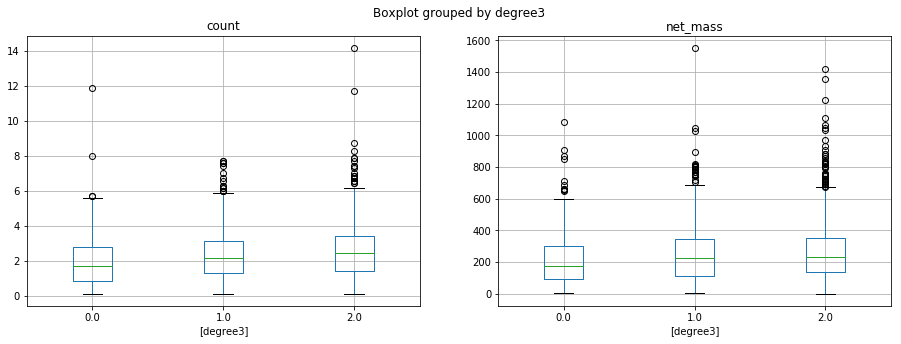

['Légumes', 'Fruits']


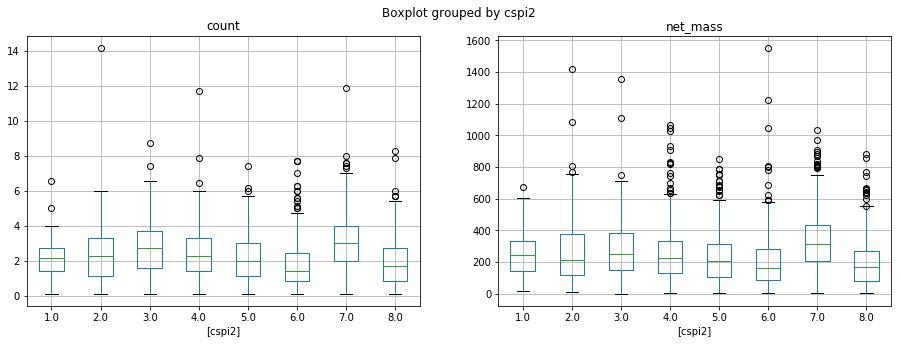

['Industriel']


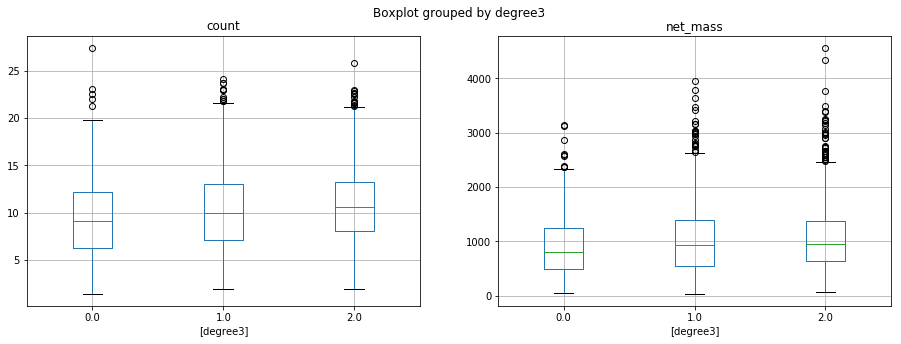

['Industriel']


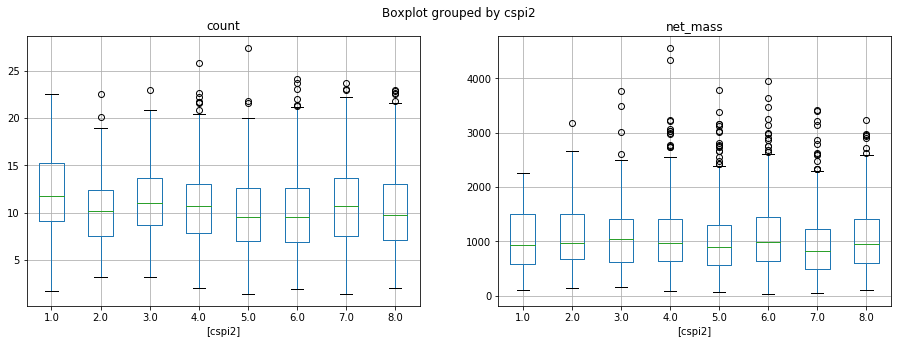

             typal3
Industriel   294492
Fait maison   97949
Autre        137238
8             11847


In [13]:
def boxplots_Habits(selection_label, selected_feats, category):
    df = pd.DataFrame()
    df["count"] = dfConso[dfConso.apply(lambda x : x[selection_label] in selected_feats, axis=1)].groupby(["nomen"])[selection_label].count().apply(lambda x : x/7)
    df["net_mass"] = dfConso[dfConso.apply(lambda x : x[selection_label] in selected_feats, axis=1)].groupby(["nomen"])["qte_nette"].sum().apply(lambda x : x/7).values
    listFeats = ["nomen", category]
    df = df.merge(dfIndivO18[listFeats], left_on="nomen", right_on="nomen", how="left")
    print(mapCorrespondances(selected_feats, selection_label))
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    df[["count", category]].boxplot(by=category, ax=ax[0])
    df[["net_mass", category]].boxplot(by=category, ax=ax[1])
    plt.show()
    
# listGroups = [23, 25, 26]
# dfVeggie = pd.DataFrame()
# dfVeggie["count"] = dfConso[dfConso.apply(lambda x : x["codgr"] in listGroups, axis=1)].groupby(["nomen"])["codgr"].count().apply(lambda x : x/7)
# dfVeggie["net_mass"] = dfConso[dfConso.apply(lambda x : x["codgr"] in listGroups, axis=1)].groupby(["nomen"])["qte_nette"].sum().apply(lambda x : x/7).values
# listFeats = ["nomen", "cspi2"]
# dfVeggie = dfVeggie.merge(dfIndivO18[listFeats], left_on="nomen", right_on="nomen", how="left")
# dfVeggie.head()

boxplots_Habits("codgr", [23, 26], "degree3")
boxplots_Habits("codgr", [23, 26], "cspi2")

boxplots_Habits("typal3", [1], "degree3")
boxplots_Habits("typal3", [1], "cspi2")

countDistribution(dfConso, "typal3")

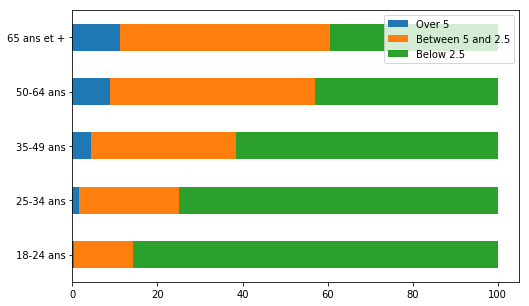

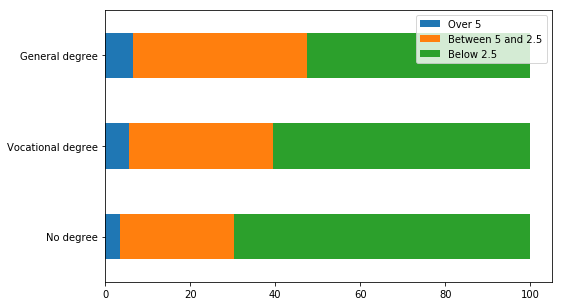

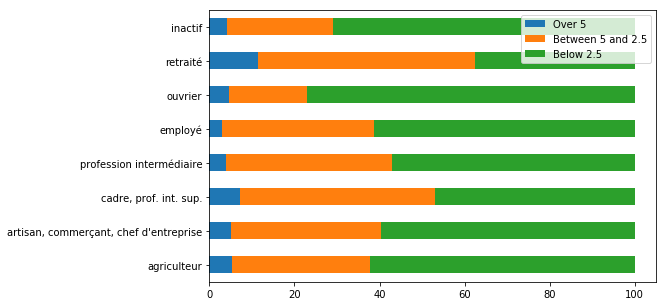

In [23]:
def stacked_Vegan_count(category, selection_label = "codgr", selected_feats = [23, 26]):
    df = pd.DataFrame()
    df["count"] = dfConso[dfConso.apply(lambda x : x[selection_label] in selected_feats, axis=1)].groupby(["nomen"])[selection_label].count().apply(lambda x : x/7)
    df["net_mass"] = dfConso[dfConso.apply(lambda x : x[selection_label] in selected_feats, axis=1)].groupby(["nomen"])["qte_nette"].sum().apply(lambda x : x/7).values
    listFeats = ["nomen", category]
    df = df.merge(dfIndivO18[listFeats], left_on="nomen", right_on="nomen", how="left")
    dfCount = df.groupby(category).count()["count"]
    dfOver5 = df[df["count"]>=5].groupby(category).count()["count"]*100/dfCount.values
    dfOver2_5 = df[df["count"]>=2.5][df["count"]<5].groupby(category).count()["count"]*100/dfCount.values
    dfBelow2_5 = df[df["count"]<2.5].groupby(category).count()["count"]*100/dfCount.values
    dfResults=pd.DataFrame()
    dfResults["Over 5"] = dfOver5
    dfResults["Between 5 and 2.5"] = dfOver2_5.values
    dfResults["Below 2.5"] = dfBelow2_5.values
    if category=="degree3":
        dfResults.index = ['No degree', 'Vocational degree', 'General degree']
    else:
        dfResults.index = mapCorrespondances(dfResults.index.values, category)
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    dfResults.plot.barh(stacked=True, ax=ax)
    plt.show()
    
stacked_Vegan_count("tage")
stacked_Vegan_count("degree3")
stacked_Vegan_count("cspi2")

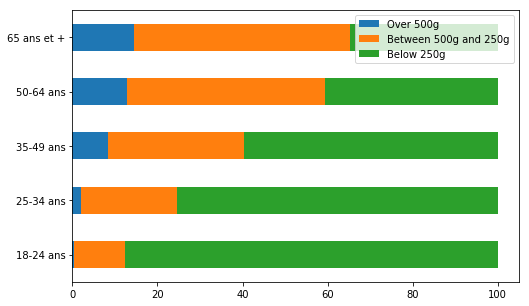

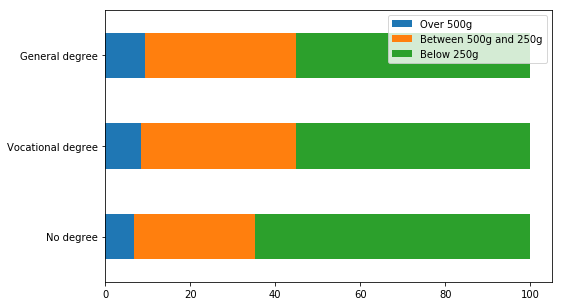

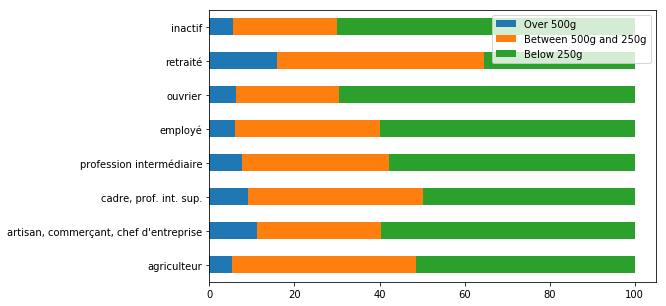

In [20]:
def stacked_Vegan_mass(category, selection_label = "codgr", selected_feats = [23, 26]):
    df = pd.DataFrame()
    df["count"] = dfConso[dfConso.apply(lambda x : x[selection_label] in selected_feats, axis=1)].groupby(["nomen"])[selection_label].count().apply(lambda x : x/7)
    df["net_mass"] = dfConso[dfConso.apply(lambda x : x[selection_label] in selected_feats, axis=1)].groupby(["nomen"])["qte_nette"].sum().apply(lambda x : x/7).values
    listFeats = ["nomen", category]
    df = df.merge(dfIndivO18[listFeats], left_on="nomen", right_on="nomen", how="left")
    dfCount = df.groupby(category).count()["count"]
    dfOver5 = df[df["net_mass"]>=500].groupby(category).count()["net_mass"]*100/dfCount.values
    dfOver2_5 = df[df["net_mass"]>=250][df["net_mass"]<500].groupby(category).count()["net_mass"]*100/dfCount.values
    dfBelow2_5 = df[df["net_mass"]<250].groupby(category).count()["net_mass"]*100/dfCount.values
    dfResults=pd.DataFrame()
    dfResults["Over 500g"] = dfOver5
    dfResults["Between 500g and 250g"] = dfOver2_5.values
    dfResults["Below 250g"] = dfBelow2_5.values
    if category=="degree3":
        dfResults.index = ['No degree', 'Vocational degree', 'General degree']
    else:
        dfResults.index = mapCorrespondances(dfResults.index.values, category)
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    dfResults.plot.barh(stacked=True, ax=ax)
    plt.show()
    
stacked_Vegan_mass("tage")
stacked_Vegan_mass("degree3")
stacked_Vegan_mass("cspi2")

In [29]:
df_social2 = dfI.loc[(dfI["social class"].isin(["worker", "student", "retiree", "intermediate profession", "corporate manager, intellectual", "employee", "farmer", "craftsman, shopkeeper, business owner"]))]
print(df_social2.head())
def data_Vegan(category, lower, upper, selection_label = "codgr", selected_feats = [23, 26]):
    df = pd.DataFrame()
    df["count"] = dfConso[dfConso.apply(lambda x : x[selection_label] in selected_feats, axis=1)].groupby(["nomen"])[selection_label].count().apply(lambda x : x/7)
#     df["net_mass"] = dfConso[dfConso.apply(lambda x : x[selection_label] in selected_feats, axis=1)].groupby(["nomen"])["qte_nette"].sum().apply(lambda x : x/7).values
    listFeats = ["nomen", category]
    df = df.merge(df_social2[listFeats], left_on="nomen", right_on="nomen", how="left")
    dfCount = df.groupby(category).count()["count"]
    dfResults = pd.DataFrame()
    dfResults["count"] = df[df["count"]<upper][df["count"]>=lower].groupby(category).count()["count"]
    dfResults["percent"] = dfResults["count"]*100/dfCount.values
    return(dfResults)

    nomen       bmi              living place weekly physical exercise  \
0  110006  31.24524                     rural                   8h-12h   
1  110007  24.22145                     rural                      <4h   
2  110020  33.21799                     rural                      <4h   
3  110021  22.93975  2,000-20,000 inhabitants                      <4h   
4  110025  20.93664  2,000-20,000 inhabitants                    4h-8h   

  daily time sitted             degree  \
0               <2h  Vocational degree   
1             2h-4h  Vocational degree   
2             4h-6h     General degree   
3               >8h          No degree   
4             2h-4h  Vocational degree   

                             exact degree          fastfood  \
0        Primary school certificate (CEP)  <1 day per month   
1  Vocational degree (below baccalauréat)  <1 day per month   
2                    General baccalauréat             never   
3           No degree (no further detail)         

In [30]:
dfV500 = data_Vegan("social class", 5, 40)
dfV250 = data_Vegan("social class", 2.5, 5)
dfV000 = data_Vegan("social class", 0, 2.5)

In [31]:
file = "outputs/5fruits&veg.html"

output_file(file)

cats = list(dfV500.index)

source = ColumnDataSource(data=dict(
    cats=cats,
    percent500=dfV500["percent"],
    count500=dfV500["count"],
    percent250=dfV250["percent"],
    count250=dfV250["count"],
    percent000=dfV000["percent"],
    count000=dfV000["count"],
    percentMid=dfV500["percent"]+dfV250["percent"]
))

hover = HoverTool(
    tooltips = [
        ("%", "@percent500"),
        ("n", "@count500"),
        ("category", "@cats")
    ],
    names = ["bar500"],
)

hover1 = HoverTool(
    tooltips = [
        ("%", "@percent250"),
        ("n", "@count250"),
        ("category", "@cats")
    ],
    names = ["bar250"],
)

hover2 = HoverTool(
    tooltips = [
        ("%", "@percent000"),
        ("n", "@count000"),
        ("category", "@cats")
    ],
    names = ["bar000"],
)

p = figure(tools="pan,wheel_zoom,box_zoom,reset", x_range=cats, title='Amount of fruits and vegetables eaten per day', plot_width=800,y_axis_label='%')
p.add_tools(hover, hover1, hover2)
p.vbar('cats', 0.7, 0, 'percent500', name="bar500", fill_color="green", line_color="black", source=source, legend='Over 5 per day')
p.vbar('cats', 0.7, 'percent500', 'percentMid', name="bar250", fill_color="yellow", line_color="black", source=source, legend='Between 2.5 and 5 per day')
p.vbar('cats', 0.7, 'percentMid', 100, name="bar000", fill_color="orange", line_color="black", source=source, legend='Below 5 per day')

p.y_range.start = 0
p.xaxis.major_label_orientation = -0.8
p.xgrid.grid_line_color = None

show(p)
save(p)

'C:\\Users\\josep\\Desktop\\EPFL_Courses\\Ada\\ADAX-project\\project\\outputs\\5fruits&veg.html'

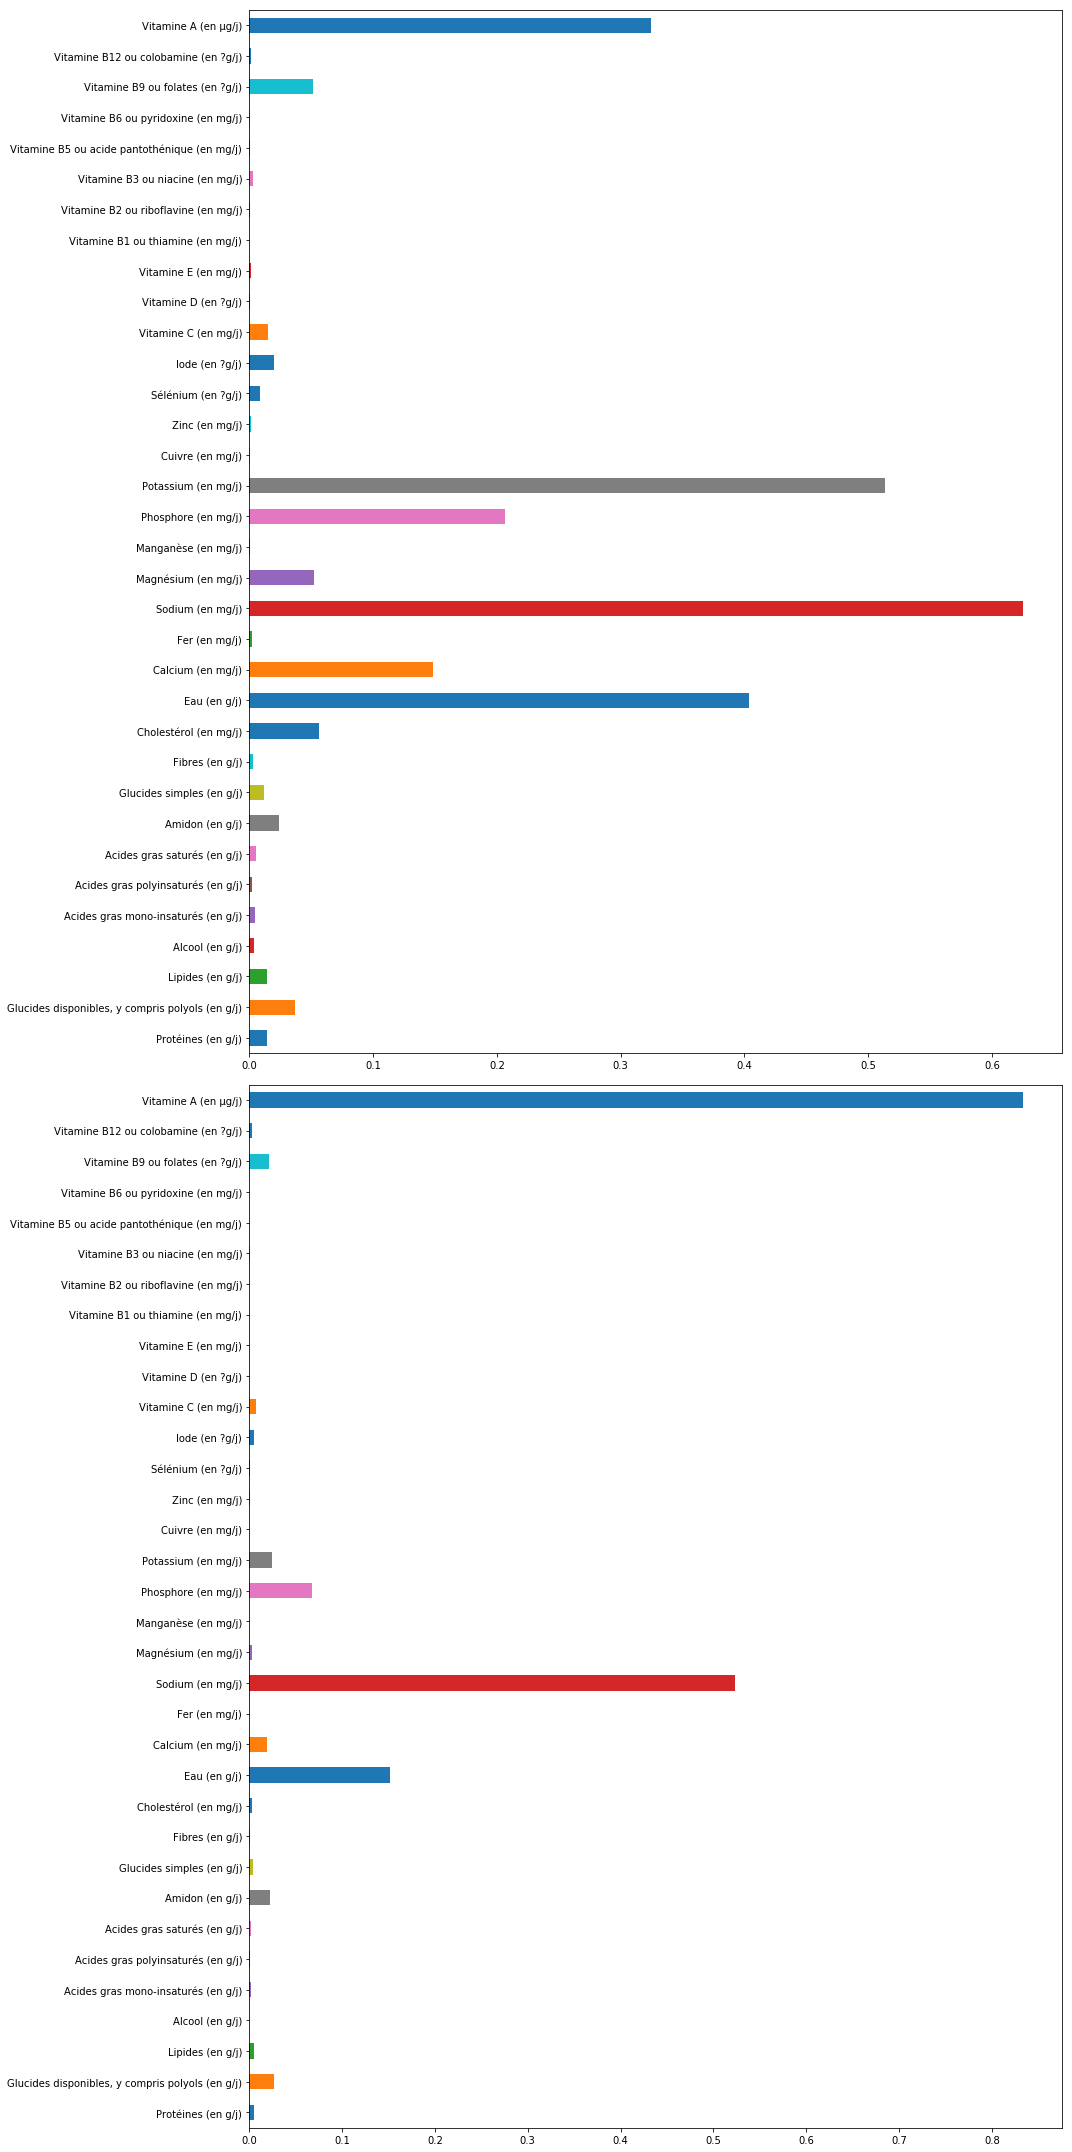

In [16]:
nutritionFeatures = ["nutj{}".format(i) for i in range(4, 8)]\
            + ["nutj{}".format(i) for i in range(8, 29)]\
            + ["nutj{}".format(i) for i in range(30, 40)]\

dfPCA = dfIndnut[nutritionFeatures]
dfPCA["Vitamine A (en µg/j)"] = dfPCA["nutj27"] + dfPCA["nutj28"]/6

dfPCA = dfPCA.drop(columns=["nutj27", "nutj28"])

pca = PCA(n_components=2)
pca.fit(dfPCA)
dfPcaComp = pd.DataFrame(pca.components_)

dfPcaComp.columns = mapDescription(dfPCA.columns.values[:-1]) + ["Vitamine A (en µg/j)"]
dfPcaComp.stack()
fig, ax = plt.subplots(2, 1, figsize=(15, 30))
dfPcaComp.stack().loc[0].apply(lambda x : np.abs(x)).plot.barh(ax=ax[0])
dfPcaComp.stack().loc[1].apply(lambda x : np.abs(x)).plot.barh(ax=ax[1])
plt.tight_layout()

Text(0.5,1,'PCA scatter plot')

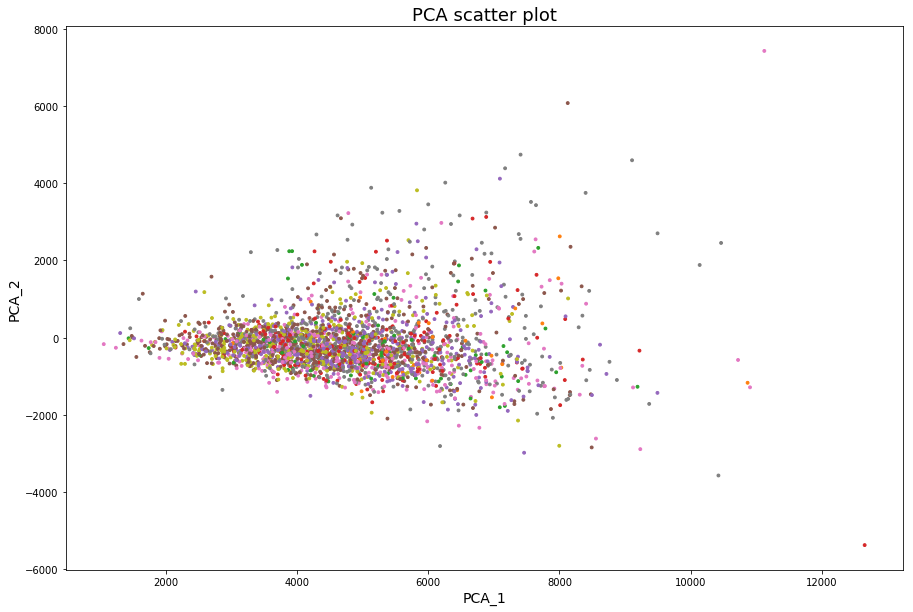

In [17]:
sorting_parameter = "cspi2"

nutritionFeatures = ["nutj{}".format(i) for i in range(4, 8)]\
            + ["nutj{}".format(i) for i in range(8, 29)]\
            + ["nutj{}".format(i) for i in range(30, 40)] #Remove 8 to remove alcohol
dfPoints = dfIndnut[["nomen"] + nutritionFeatures].merge(dfIndivO18[["nomen", sorting_parameter]], on="nomen", how="inner")

dfPoints["nutj27-28"] = dfPoints["nutj27"] + dfPoints["nutj28"]/6
dfPoints = dfPoints.drop(columns=["nutj27", "nutj28"])

dfPcaComp = pd.DataFrame(pca.components_)
nutritionFeatures = ["nutj{}".format(i) for i in range(4, 8)]\
            + ["nutj{}".format(i) for i in range(8, 27)]\
            + ["nutj{}".format(i) for i in range(30, 40)]\
            + ["nutj27-28"]
dfPcaComp.columns = nutritionFeatures

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
N = dfPoints.shape[0]
X = np.zeros(N)
Y = np.zeros(N)
C = ['' for i in range(N)]
for i in range(N):
    X[i]=np.dot(pca.components_[0], dfPoints[nutritionFeatures].loc[i].values)
    Y[i]=np.dot(pca.components_[1], dfPoints[nutritionFeatures].loc[i].values)
    C[i]= 'C' + str(dfPoints[sorting_parameter].loc[i].astype(int))


ax.scatter(X, Y, marker = 'o', s=8, alpha  = 1, c=C)
ax.set_xlabel("PCA_1", fontsize = 14)
ax.set_ylabel("PCA_2", fontsize = 14)
ax.set_title("PCA scatter plot", fontsize = 18)
# print(C)